<a href="https://colab.research.google.com/github/DavidScanu/oc-ai-engineer-p06-classifier-biens-consommation/blob/main/notebooks/david_scanu_p06_notebook_02_classification_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet 6 - Classifiez automatiquement des biens de consommation

> 🎓 OpenClassrooms • Parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) | 👋 *Étudiant* : [David Scanu](https://www.linkedin.com/in/davidscanu14/)

## 🖼️ Partie 2 : Classification supervisée d'images avec data augmentation

Dans cette seconde partie de notre projet, nous allons mettre en œuvre une **classification supervisée d'images** pour les produits de notre place de marché.

Après avoir étudié la **faisabilité du regroupement automatique** dans la première partie, nous approfondissons maintenant notre approche en développant un modèle capable de prédire directement la catégorie d'un produit à partir de son image;

Pour optimiser les performances de notre modèle malgré un jeu de données relativement limité, nous utiliserons la technique de [data augmentation](https://datascientest.com/data-augmentation-tout-savoir) qui permet de générer artificiellement des variations d'images d'entraînement.

Nous avons choisi d'implémenter une approche par [transfer learning](https://datascientest.com/transfer-learning) avec l'architecture [ResNet50](https://keras.io/api/applications/resnet/#resnet50-function), reconnue pour ses excellentes performances en classification d'images. Cette méthode nous permettra de bénéficier des connaissances préalables du réseau tout en l'**adaptant spécifiquement à nos catégories de produits**.

## 📝 Contexte

Dans le cadre de ma formation de [AI Engineer chez OpenClassrooms](https://openclassrooms.com/fr/paths/795-ai-engineer), ce projet s'inscrit dans un scénario professionnel où j'interviens en tant que Data Scientist au sein de l'entreprise **"Place de marché"**, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant **une photo et une description**. Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l'instant très petit.

## ⚡ Mission

> Développer un moteur de classification automatique d'articles basé sur les images et les descriptions textuelles.

Réaliser une étude de faisabilité complète comprenant :

1. **Prétraitement des données texte et image** : Nettoyage et préparation des données
2. **Extraction de features** : Approches diverses pour texte et images
   - **Pour les images** : Algorithmes SIFT/ORB/SURF et CNN Transfer Learning
   - **Pour les textes** : Bag-of-words, TF-IDF, Word2Vec/Glove/FastText, BERT, et Universal Sentence Encoder
3. **Analyse de faisabilité** : Réduction dimensionnelle et visualisation, mesure de similarité
4. **Classification supervisée** : Implémentation d'un modèle de classification d'images
5. **Test d'API** : Extraction de données de produits via l'API OpenFood Facts

## 📍 Résumé de l'approche

Dans ce projet, nous avons:

1. **Préparé l'environnement** en créant une structure de dossiers pour organiser les artefacts d'entraînement
2. **Préparé les données** en chargeant et prétraitant les images
3. **Mis en place la data augmentation** pour améliorer la généralisation du modèle
4. **Créé un modèle** basé sur ResNet50 avec transfer learning
5. **Entraîné le modèle** en deux phases: entraînement initial et fine-tuning
6. **Évalué le modèle** avec des métriques de performance détaillées
7. **Visualisé les résultats** pour mieux comprendre le comportement du modèle
8. **Sauvegardé tous les artefacts** nécessaires pour une utilisation future

Cette approche vous donne un **pipeline complet pour la classification d'images** avec un modèle performant basé sur ResNet50 et optimisé par data augmentation.

## 💾 Connection à Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🖼️ Vérification du GPU

In [ ]:
import tensorflow as tf
info = tf.sysconfig.get_build_info()
print("TF version   :", tf.__version__)
print("CUDA version :", info.get("cuda_version"))
print("cuDNN version:", info.get("cudnn_version"))

TF version   : 2.18.0
CUDA version : 12.5.1
cuDNN version: 9


In [ ]:
# 1. Vérifier si un GPU est disponible et l'afficher
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs disponibles: {len(gpus)}")
    for gpu in gpus:
        print(f"Nom du GPU: {gpu}")
    # Configurer TensorFlow pour utiliser le premier GPU
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Croissance mémoire GPU activée")
    except RuntimeError as e:
        print(f"Erreur lors de la configuration de la mémoire GPU: {e}")
else:
    print("Aucun GPU disponible, utilisation du CPU")

# 2. Vérifier l'appareil sur lequel TensorFlow s'exécute
print(f"Appareil TensorFlow par défaut: {tf.config.list_physical_devices()}")
print(f"Appareil de calcul par défaut: {tf.device('/')}")

GPUs disponibles: 1
Nom du GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Croissance mémoire GPU activée
Appareil TensorFlow par défaut: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Appareil de calcul par défaut: <tensorflow.python.eager.context._EagerDeviceContext object at 0x7f1188352cc0>


In [ ]:
!nvidia-smi

Fri May  2 06:50:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P0             30W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 🐍 Importation des bibliothèques Python

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import requests
import zipfile
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm

## 💿 Chargement du jeu de données

In [ ]:
# Création du dossier de destination si nécessaire
g_drive_dir = "/content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content"
destination_folder = os.path.join(g_drive_dir, "data")
csv_path = os.path.join(destination_folder, "Flipkart/flipkart_com-ecommerce_sample_1050.csv")
os.makedirs(destination_folder, exist_ok=True)

# Vérification si les données existent déjà
if not os.path.exists(csv_path):
    # Téléchargement et extraction des données
    url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip"
    r = requests.get(url)
    zip_path = os.path.join(destination_folder, "dataset.zip")

    with open(zip_path, 'wb') as f:
        f.write(r.content)

    # Extraction du zip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)

    # Suppression du fichier .zip
    os.remove(zip_path)

    print("Données téléchargées et extraites avec succès")
else:
    print("Les données existent déjà")


# Chargement des données
df = pd.read_csv(csv_path)

print(df.shape)

# Affichage des premières lignes pour comprendre la structure des données
df.head()

Les données existent déjà
(1050, 15)


uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [ ]:
for col in df.columns :
    print("-", col)

- uniq_id
- crawl_timestamp
- product_url
- product_name
- product_category_tree
- pid
- retail_price
- discounted_price
- image
- is_FK_Advantage_product
- description
- product_rating
- overall_rating
- brand
- product_specifications


In [ ]:
print(df['product_category_tree'].value_counts())

product_category_tree
["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                                                                                                            56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                                                                                                              26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                                                                                                     23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                                                                                                            22
["Home Furnishing >> Bath Linen >> Towels"]                                                                                                                              19
                                                                                                                      

## 🛒 Extraction des catégories

In [ ]:
# Inspecter la structure des données de catégorie
print(df['product_category_tree'].iloc[0])

# Nettoyer et extraire la catégorie principale
def extract_main_category(category_tree):
    if pd.isna(category_tree):
        return "Unknown"

    # Supprimer les caractères [""] et diviser par >>
    try:
        # Enlever les crochets et guillemets
        clean_tree = category_tree.strip('[]"')
        # Diviser par >>
        categories = clean_tree.split(">>")
        # Prendre la première catégorie (niveau principal) et nettoyer les espaces
        main_category = categories[0].strip()
        return main_category
    except:
        return "Error"

# Extraire la catégorie principale
df['main_category'] = df['product_category_tree'].apply(extract_main_category)

# Afficher les catégories principales
print(df['main_category'].value_counts())

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]
main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


In [ ]:
df['main_category'].nunique()

7

## 🖼️ Association des chemins d'images au DataFrame

In [ ]:
# Vérification du chemin des images
# image_dir = "/content/content/data/Flipkart/Images"
image_dir = os.path.join(g_drive_dir, "data/Flipkart/Images")
if not os.path.exists(image_dir):
    print(f"Dossier d'images introuvable. Veuillez vérifier le chemin: {image_dir}")
else:
    print(f"Dossier d'images trouvé: {image_dir}")

# Association des chemins d'images au DataFrame
df['image_path'] = df['image'].apply(lambda x: os.path.join(image_dir, x) if isinstance(x, str) else None)

# Vérification de l'existence des images
def check_image_exists(image_path):
    if image_path is None:
        return False
    return os.path.exists(image_path)

df['image_exists'] = df['image_path'].apply(check_image_exists)
print(f"Images trouvées: {df['image_exists'].sum()} sur {len(df)}")

Dossier d'images trouvé: /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/data/Flipkart/Images
Images trouvées: 1050 sur 1050


In [ ]:
# Filtrer pour garder seulement les entrées avec images existantes
df_with_images = df[df['image_exists']].copy()
print(f"Nombre d'entrées avec images valides: {len(df_with_images)}")

# Vérifier la répartition des catégories dans le sous-ensemble
print("Répartition des catégories principales:")
print(df_with_images['main_category'].value_counts())

Nombre d'entrées avec images valides: 1050
Répartition des catégories principales:
main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


In [ ]:
# Limiter le nombre d'échantillons par catégorie pour équilibrer
samples_per_category = 150  # ajustez selon vos besoins
df_balanced = pd.DataFrame()

for category in df_with_images['main_category'].unique():
    category_samples = df_with_images[df_with_images['main_category'] == category].sample(
        min(samples_per_category, len(df_with_images[df_with_images['main_category'] == category])),
        random_state=42
    )
    df_balanced = pd.concat([df_balanced, category_samples])

print(f"Nombre d'entrées après équilibrage: {len(df_balanced)}")
print("Nouvelle répartition des catégories:")
print(df_balanced['main_category'].value_counts())

Nombre d'entrées après équilibrage: 1050
Nouvelle répartition des catégories:
main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


## 📁 Préparation de l'environnement

In [ ]:
datetime.now().strftime("%Y%m%d_%H%M%S")

'20250502_081703'

In [ ]:
import os
import time
from datetime import datetime

# Création du dossier principal d'entraînement
train_folder = os.path.join(g_drive_dir, "train")
os.makedirs(train_folder, exist_ok=True)

# Création d'un sous-dossier unique pour cette session d'entraînement
run_folder = os.path.join(train_folder, f"run_20250502_091252")
os.makedirs(run_folder, exist_ok=True)

# Dossier de prétraitement commun
preprocessing_folder = os.path.join(run_folder, "preprocessing")
os.makedirs(preprocessing_folder, exist_ok=True)

# Définir les chemins pour la phase 1
phase1_folder = os.path.join(run_folder, "phase1_standard")
phase1_models_folder = os.path.join(phase1_folder, "models")
phase1_visualizations_folder = os.path.join(phase1_folder, "visualizations")
phase1_logs_folder = os.path.join(phase1_folder, "logs")
phase1_metrics_folder = os.path.join(phase1_folder, "metrics")

# Définir les chemins pour la phase 2
phase2_folder = os.path.join(run_folder, "phase2_finetuning")
phase2_models_folder = os.path.join(phase2_folder, "models")
phase2_visualizations_folder = os.path.join(phase2_folder, "visualizations")
phase2_logs_folder = os.path.join(phase2_folder, "logs")
phase2_metrics_folder = os.path.join(phase2_folder, "metrics")

# Créer tous les dossiers
for folder in [
    phase1_folder, phase1_models_folder, phase1_visualizations_folder, phase1_logs_folder, phase1_metrics_folder,
    phase2_folder, phase2_models_folder, phase2_visualizations_folder, phase2_logs_folder, phase2_metrics_folder
]:
    os.makedirs(folder, exist_ok=True)

print(f"Structure de dossiers pour les deux phases créée dans: {run_folder}")
print(f"Phase 1 (entraînement standard): {phase1_folder}")
print(f"Phase 2 (fine-tuning): {phase2_folder}")

Structure de dossiers pour les deux phases créée dans: /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/train/run_20250502_091252
Phase 1 (entraînement standard): /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/train/run_20250502_091252/phase1_standard
Phase 2 (fine-tuning): /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/train/run_20250502_091252/phase2_finetuning


Voici un schéma de la structure des fichiers, reflétant les dossiers créés par le script python qui ci-dessus :

```markdown
run_20250502_075651/
├── preprocessing/        # Dossier original pour le prétraitement
├── phase1_standard/      # Dossier pour l'entraînement standard
│   ├── models/           # Modèles de la phase 1
│   ├── visualizations/   # Visualisations de la phase 1
│   └── logs/             # Logs de la phase 1
└── phase2_finetuning/    # Dossier pour le fine-tuning
    ├── models/           # Modèles de la phase 2
    ├── visualizations/   # Visualisations de la phase 2
    └── logs/             # Logs de la phase 2
```

## 🧹 Préparation des données d'images pour la classification

Nous préparons notre jeu de données d'images pour l'entraînement du modèle de classification. Notre approche méthodique comprend les étapes suivantes :

- **Encodage des catégories** : Nous utilisons **LabelEncoder** pour transformer nos catégories textuelles en valeurs numériques, facilitant leur traitement par le modèle.
- **Chargement parallèle des images** : Nous implémentons un système de chargement multithreadé qui améliore considérablement les performances en traitant les images par lots.
- **Prétraitement des images** : Chaque image est redimensionnée à 224×224 pixels (format requis par ResNet50) et convertie de BGR à RGB pour une interprétation correcte des couleurs.
- **Partitionnement des données** : Nous divisons notre jeu de données en respectant les proportions 64%/16%/20% pour l'entraînement, la validation et le test, tout en préservant la distribution des catégories grâce au paramètre stratify.
- **Visualisation d'échantillons** : Nous affichons quelques images d'exemple avec leurs catégories correspondantes pour vérifier visuellement la qualité et la diversité de nos données.

Mapping des catégories:
0 | Baby Care
1 | Beauty and Personal Care
2 | Computers
3 | Home Decor & Festive Needs
4 | Home Furnishing
5 | Kitchen & Dining
6 | Watches
Chargement parallèle des images...


  0%|          | 0/21 [00:00<?, ?it/s]

Images chargées: 1048 sur 1050
Forme des données d'entraînement: (670, 224, 224, 3)
Forme des données de validation: (168, 224, 224, 3)
Forme des données de test: (210, 224, 224, 3)


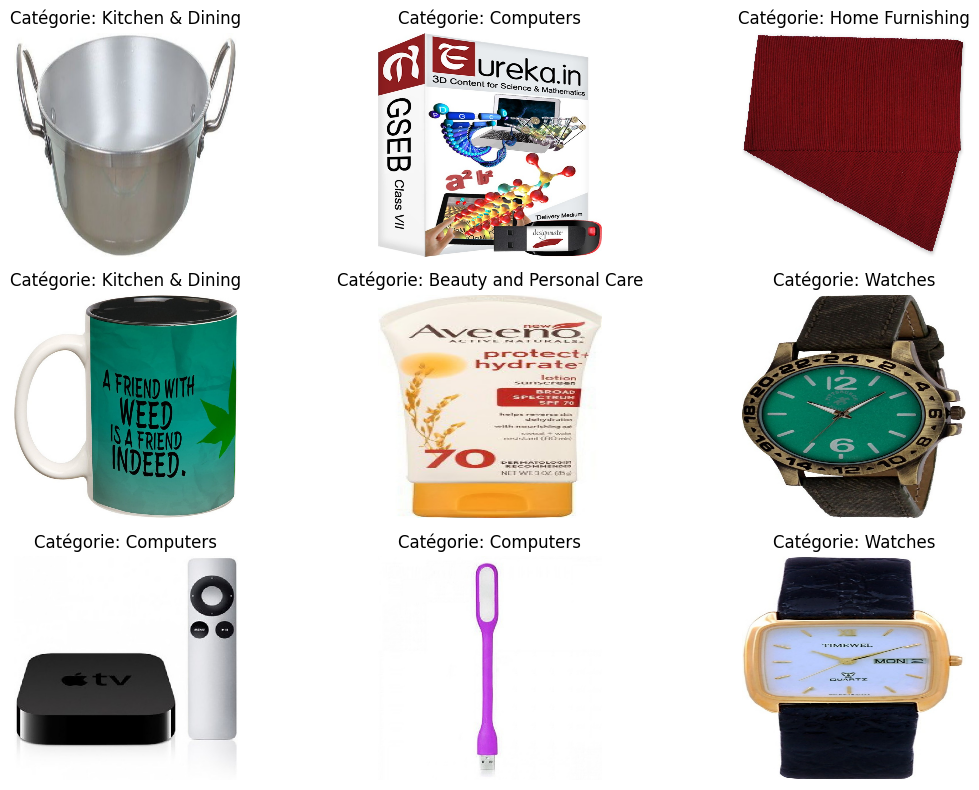

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.preprocessing import LabelEncoder
import concurrent.futures
from tqdm.notebook import tqdm

# Définir la taille d'image attendue par ResNet50
IMG_SIZE = (224, 224)

# Encodage des étiquettes de catégorie
label_encoder = LabelEncoder()
df_balanced['encoded_category'] = label_encoder.fit_transform(df_balanced['main_category'])

# Sauvegarder le label encoder
import pickle
with open(os.path.join(preprocessing_folder, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

# Afficher le mapping des catégories
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping des catégories:")
for category, code in category_mapping.items():
    print(f"{code} | {category}")

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(image_path, img_size=IMG_SIZE):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        return img
    except Exception as e:
        return None

# Fonction pour traiter un lot d'images
def process_batch(batch_indices, df):
    batch_X = []
    batch_y = []
    batch_valid_indices = []

    for idx in batch_indices:
        img = load_and_preprocess_image(df.iloc[idx]['image_path'])
        if img is not None:
            batch_X.append(img)
            batch_y.append(df.iloc[idx]['encoded_category'])
            batch_valid_indices.append(idx)

    return batch_X, batch_y, batch_valid_indices

# Traitement parallèle des images
def parallel_process_images(df, n_workers=4, batch_size=50):
    all_indices = list(range(len(df)))
    batches = [all_indices[i:i + batch_size] for i in range(0, len(all_indices), batch_size)]

    X_all, y_all, valid_indices_all = [], [], []

    with concurrent.futures.ThreadPoolExecutor(max_workers=n_workers) as executor:
        future_to_batch = {executor.submit(process_batch, batch, df): batch for batch in batches}

        for future in tqdm(concurrent.futures.as_completed(future_to_batch), total=len(batches)):
            batch_X, batch_y, batch_valid_indices = future.result()
            X_all.extend(batch_X)
            y_all.extend(batch_y)
            valid_indices_all.extend(batch_valid_indices)

    return np.array(X_all), np.array(y_all), valid_indices_all

print("Chargement parallèle des images...")
# Utiliser 4 workers et un batch de 50 images par worker
X, y, valid_indices = parallel_process_images(df_balanced, n_workers=4, batch_size=50)

print(f"Images chargées: {len(X)} sur {len(df_balanced)}")

# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Séparation de l'ensemble de validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Forme des données d'entraînement: {X_train.shape}")
print(f"Forme des données de validation: {X_val.shape}")
print(f"Forme des données de test: {X_test.shape}")

# Visualiser quelques exemples
plt.figure(figsize=(12, 8))
for i in range(min(9, len(X_train))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Catégorie: {label_encoder.inverse_transform([y_train[i]])[0]}")
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(phase1_visualizations_folder, 'exemples_images.png'))
plt.show()

## 📈 Mise en place de la Data Augmentation

Nous mettons en place une stratégie de **data augmentation** pour enrichir artificiellement notre jeu de données d'entraînement.

Cette technique nous permet d'améliorer la robustesse et les performances de notre modèle :

- **Configuration de la data augmentation** : Nous appliquons plusieurs transformations aléatoires aux images d'entraînement, incluant des rotations (±10°), des translations horizontales et verticales (±10%), des cisaillements (±30%), des zooms (±10%) et des retournements horizontaux.
- **Préparation des générateurs** : Nous créons trois flux de données distincts - un pour l'entraînement avec augmentation, et deux autres pour la validation et le test avec uniquement le prétraitement standard de ResNet50.
- **Correction d'affichage** : Nous implémentons une fonction qui inverse le prétraitement pour visualiser correctement les images augmentées, en tenant compte des spécificités de normalisation de ResNet50.
- **Visualisation des augmentations** : Nous affichons des exemples d'images augmentées pour vérifier visuellement l'effet des transformations et leur pertinence pour notre tâche de classification.

Cette approche génère des variations réalistes de nos images originales, permettant au modèle de mieux généraliser.

In [ ]:
# Créer les couches d'augmentation en dehors des fonctions (au niveau global)
random_flip = tf.keras.layers.RandomFlip("horizontal")
random_rotation = tf.keras.layers.RandomRotation(
    factor=0.055,  # ±10 degrés (0.055 ≈ 10/180)
    fill_mode='nearest',
    interpolation='nearest'
)

# Fonction d'augmentation sans création de couches
@tf.function
def augment_image(image, label):
    # Conversion en float32 et normalisation
    image = tf.cast(image, tf.float32)

    # Appliquer le flip horizontal
    image = random_flip(tf.expand_dims(image, 0))[0]

    # Appliquer la rotation
    image = random_rotation(tf.expand_dims(image, 0))[0]

    # Modifications d'intensité légères
    image = tf.image.random_brightness(image, 0.15)
    image = tf.image.random_contrast(image, 0.90, 1.1)
    image = tf.image.random_saturation(image, 0.85, 1.15)
    image = tf.image.random_hue(image, 0.05)

    return image, label

# Fonction qui combine l'augmentation et le prétraitement final
@tf.function
def augment_image_for_training(image, label):
    # Appliquer l'augmentation
    image, label = augment_image(image, label)

    # Appliquer le prétraitement
    image = preprocess_input(image)

    return image, label

# Fonction de prétraitement pour les images non augmentées
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)  # Prétraitement ResNet50
    return image, label

Visualisation des augmentations pour la catégorie: Home Decor & Festive Needs


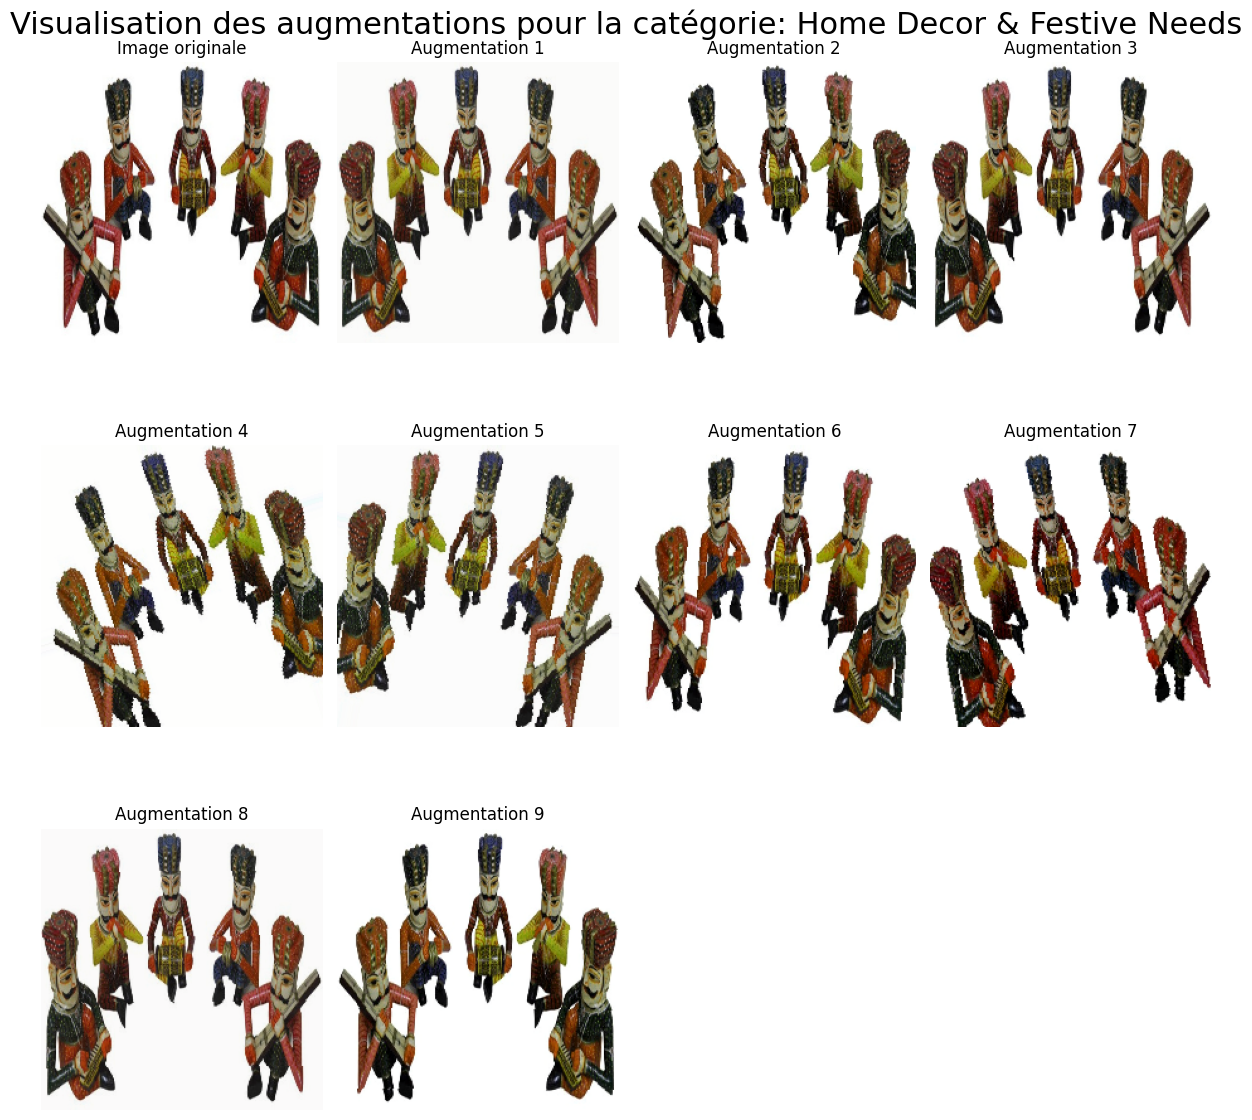

In [ ]:
# Visualiser plusieurs exemples d'augmentation d'une même image
def visualize_augmentations(original_image, category_name, num_augmentations=9):
    plt.figure(figsize=(12, 12))

    # Afficher l'image originale
    plt.subplot(3, 4, 1)
    plt.imshow(original_image/255.0)  # Normaliser pour l'affichage
    plt.title("Image originale")
    plt.axis('off')

    # Créer un tensor à partir de l'image
    img_tensor = tf.convert_to_tensor(original_image)

    # Générer et afficher plusieurs versions augmentées
    for i in range(num_augmentations):
        # Appliquer l'augmentation SANS le prétraitement final
        augmented_img, _ = augment_image(img_tensor, 0)

        # Convertir en numpy et normaliser pour l'affichage
        display_img = augmented_img.numpy() / 255.0

        # Clip pour s'assurer que les valeurs sont dans [0, 1]
        display_img = np.clip(display_img, 0, 1)

        # Afficher l'image augmentée
        plt.subplot(3, 4, i+2)
        plt.imshow(display_img)
        plt.title(f"Augmentation {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle(f'Visualisation des augmentations pour la catégorie: {category_name}', fontsize=22)
    plt.savefig(os.path.join(phase1_visualizations_folder, 'multiples_augmentations.png'))
    plt.show()

# Choisir une image de l'ensemble d'entraînement
sample_idx = np.random.randint(0, len(X_train))
sample_image = X_train[sample_idx]
sample_label = y_train[sample_idx]
print(f"Visualisation des augmentations pour la catégorie: {label_encoder.inverse_transform([sample_label])[0]}")

# Visualiser plusieurs augmentations de cette image
visualize_augmentations(sample_image, label_encoder.inverse_transform([sample_label])[0])

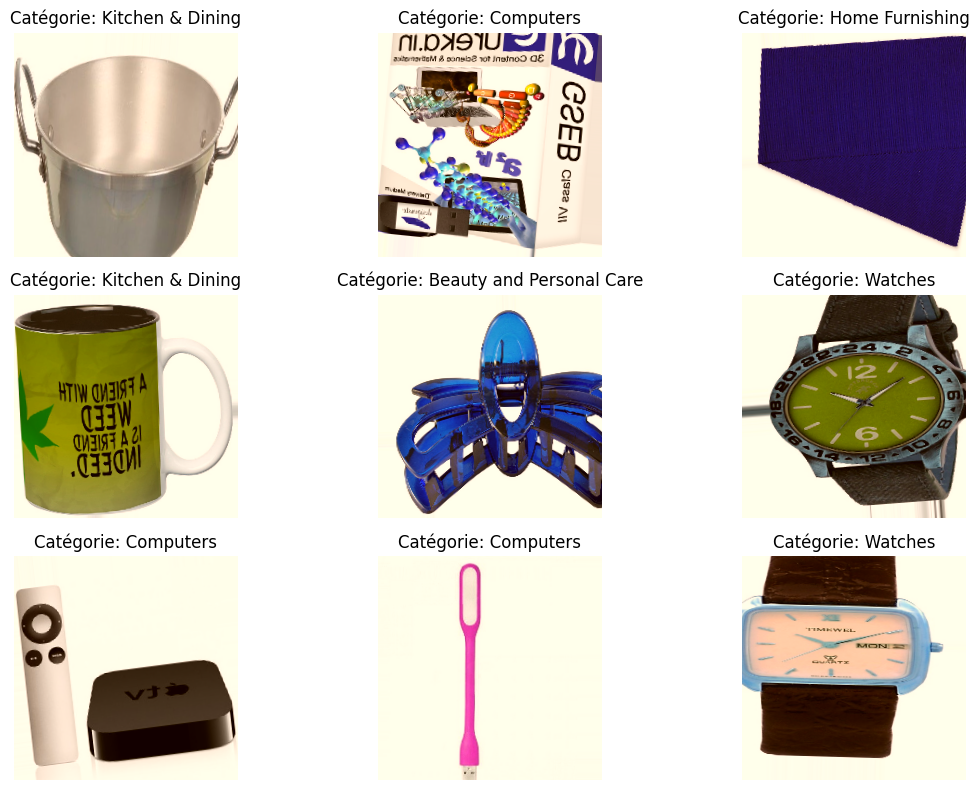

In [ ]:
# @title
# # @title Old
# # Définir les transformations pour la data augmentation
# train_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.3,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Pour la validation et le test, on fait seulement le prétraitement sans augmentation
# val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# # Préparation des générateurs
# batch_size = 32

# # Générateur d'entraînement avec data augmentation
# train_generator = train_datagen.flow(
#     X_train, y_train,
#     batch_size=batch_size,
#     shuffle=True
# )

# # Générateurs de validation et de test
# val_generator = val_datagen.flow(
#     X_val, y_val,
#     batch_size=batch_size,
#     shuffle=False
# )

# test_generator = test_datagen.flow(
#     X_test, y_test,
#     batch_size=batch_size,
#     shuffle=False
# )

# # Visualiser des exemples d'images augmentées
# def plot_augmented_images(generator, num_images=9):
#     plt.figure(figsize=(12, 8))
#     for i in range(num_images):
#         batch = next(generator)
#         image = batch[0][0]  # Premier batch, première image

#         # Correction pour l'affichage des images prétraitées par preprocess_input
#         # Le prétraitement ResNet50 soustrait la moyenne des canaux et normalise
#         # Pour l'affichage, nous devons revenir à la plage [0, 1]
#         image = np.clip(image, -123.68, 151.061)  # Limiter les valeurs extrêmes
#         image = image + [123.68, 116.779, 103.939]  # Ajouter la moyenne RGB
#         image = image / 255.0  # Normaliser à [0, 1]

#         plt.subplot(3, 3, i + 1)
#         plt.imshow(np.clip(image, 0, 1))  # Assurer que les valeurs sont entre 0 et 1
#         plt.title(f"Catégorie: {label_encoder.inverse_transform([batch[1][0]])[0]}")
#         plt.axis('off')

#     plt.tight_layout()
#     plt.savefig(os.path.join(visualizations_folder, 'exemples_augmentation.png'))
#     plt.show()

# # Créer un générateur temporaire pour visualiser l'augmentation
# temp_generator = train_datagen.flow(
#     X_train[:9], y_train[:9],
#     batch_size=1,
#     shuffle=False
# )

# plot_augmented_images(temp_generator)

## 🏗️ Création du modèle avec Transfer Learning (ResNet50)

Nous construisons notre modèle de classification en utilisant la technique du transfer learning, qui nous permet de bénéficier des connaissances préalables d'un réseau pré-entraîné :

- **Utilisation de ResNet50** : Nous importons `ResNet50`, un modèle profond `**pré-entraîné sur ImageNet**, en excluant les couches de classification pour l'adapter à notre propre tâche.
- **Gel des couches de base** : Nous figeons les poids des couches du réseau de base pour préserver les caractéristiques générales apprises sur ImageNet.
- **Architecture personnalisée** : Nous ajoutons notre propre tête de classification composée d'un pooling global, d'une couche dense de 512 neurones avec activation `ReLU`, d'un dropout de 50% pour limiter le surapprentissage.
- **Couche de sortie** : couche de sortie avec autant de neurones que de catégories et fonction d'activation `softmax`. L'activation softmax transforme les scores bruts en **distribution de probabilités**, garantissant que toutes les valeurs de sortie sont comprises entre 0 et 1 et que leur somme égale 1. Les résultats peuvent être interprétés comme des probabilités d'appartenance à chaque catégorie, le modèle attribuant à chaque image la classe correspondant au neurone ayant la plus forte activation.
- **Configuration de l'entraînement** : Nous compilons le modèle avec l'optimiseur Adam, une fonction de perte adaptée à la classification multi-classes, et suivons la métrique de précision.
- **Documentation** : Nous générons un résumé de l'architecture complète et le sauvegardons pour référence, facilitant ainsi la reproductibilité de notre expérience.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

# Nombre de classes
num_classes = len(label_encoder.classes_)

# Charger le modèle ResNet50 pré-entraîné sans la couche de classification
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches personnalisées pour la classification
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# predictions = Dense(num_classes, activation='softmax')(x)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
# x = Dropout(0.3)(x)
# predictions = Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='softmax')(x)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # 0.0005 → 0.001
x = Dropout(0.6)(x)  # 0.5 → 0.6
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # 0.0005 → 0.001
x = Dropout(0.4)(x)  # 0.3 → 0.4
predictions = Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='softmax')(x)


# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Résumé du modèle
model.summary()

# Sauvegarder l'architecture du modèle
with open(os.path.join(phase1_models_folder, 'model_architecture.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,769,927 (94.49 MB)

 Trainable params: 1,182,215 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

La régularisation L2 (aussi appelée régularisation de poids ou régularisation de Ridge) est une technique pour réduire le surapprentissage dans les modèles d'apprentissage automatique. Voici comment elle fonctionne :

> Fonctionnement de `kernel_regularizer=tf.keras.regularizers.l2(0.0005)`

1. **Principe de base** : La régularisation L2 ajoute une pénalité à la fonction de perte basée sur la somme des carrés des poids du modèle.

2. **Mathématiquement** : Si votre fonction de perte normale est `L`, la régularisation L2 modifie cette fonction à :
   ```
   L_new = L + λ * (somme des carrés des poids)
   ```
   où λ (lambda) est le coefficient de régularisation (0.0005 dans votre cas).

3. **Effet sur l'entraînement** :
   - Force les poids à rester petits et plus uniformément distribués
   - Empêche certains neurones de dominer l'apprentissage
   - Favorise les solutions plus simples (avec des poids plus petits)
   - Améliore la généralisation du modèle

4. **Paramètre de force** : La valeur 0.0005 est le coefficient de régularisation
   - Une valeur plus grande (ex: 0.01) = régularisation plus forte = poids plus petits
   - Une valeur plus petite (ex: 0.0001) = régularisation plus faible = effet moindre

5. **Application** : En l'appliquant à la couche Dense, vous pénalisez les grands poids uniquement dans cette couche spécifique.

**Pourquoi utiliser la régularisation L2**

Dans notre modèle qui montre des signes de surapprentissage (très bonne performance sur les données d'entraînement mais limitée sur les données de validation), la régularisation L2 aide à :

1. Empêcher le modèle de "mémoriser" les données d'entraînement
2. Encourager le modèle à apprendre des caractéristiques plus générales
3. Améliorer les performances sur des données jamais vues

La valeur 0.0005 est un bon point de départ - suffisamment élevée pour avoir un effet, mais pas trop forte pour empêcher l'apprentissage. nous pouvons expérimenter avec différentes valeurs (0.0001, 0.001, etc.) pour trouver l'équilibre optimal pour notre modèle.

## 🚅 Entraînement du modèle avec callbacks et optimisations GPU

Nous implémentons un pipeline d'entraînement optimisé pour maximiser les performances et la stabilité sur GPU, tout en assurant un suivi complet du processus d'apprentissage :

- **Callbacks stratégiques** : Nous mettons en place plusieurs mécanismes de contrôle, incluant la sauvegarde des meilleurs modèles, l'arrêt anticipé en cas de stagnation, la réduction adaptative du taux d'apprentissage et la journalisation TensorBoard.
- **Optimisation GPU** : Nous activons XLA (Accelerated Linear Algebra) et configurons une taille de batch adaptée aux contraintes mémoire du GPU T4.
- **Pipeline de données haute performance** : Nous utilisons l'API `tf.data` avec préfetching et parallélisation pour optimiser le chargement et le traitement des données.
- **Data augmentation avancée** : Nous implémentons des transformations d'images directement dans le pipeline TensorFlow, incluant rotations, recadrages aléatoires et ajustements de luminosité.
- **Persistance complète** : À la fin de l'entraînement, nous sauvegardons le modèle final, ses poids et l'historique d'apprentissage pour permettre analyses et déploiements ultérieurs.

In [ ]:
IS_TRAINING = True

if IS_TRAINING:

    print("="*50)
    print("PHASE 1: ENTRAÎNEMENT STANDARD")
    print("="*50)

    # Callbacks
    checkpoint = ModelCheckpoint(
        os.path.join(phase1_models_folder, 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    tensorboard = TensorBoard(
        log_dir=phase1_logs_folder,
        histogram_freq=1,
        write_graph=True
    )

    # Callback pour le suivi des performances GPU
    class GPUUtilizationCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if tf.config.list_physical_devices('GPU'):
                print(f"\nÉpoque {epoch+1}: Vérification de l'utilisation GPU")

    callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard, GPUUtilizationCallback()]

    # Optimisation des performances GPU
    # Utiliser XLA pour accélérer l'exécution
    tf.config.optimizer.set_jit(True)

    # Définir une taille de batch adaptée au GPU T4
    batch_size = 16  # Revenir à 32 qui est plus sûr pour la mémoire GPU

    # Convertir les données en datasets TensorFlow pour éviter les problèmes de générateurs
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Configurer les datasets
    AUTOTUNE = tf.data.AUTOTUNE  # Optimisation automatique

    # Dataset d'entraînement avec augmentation
    train_ds = train_ds.shuffle(buffer_size=len(X_train))
    train_ds = train_ds.map(augment_image_for_training, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(AUTOTUNE)
    train_ds = train_ds.repeat()  # Répéter indéfiniment pour éviter les épuisements de données

    # Dataset de validation
    val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(AUTOTUNE)
    val_ds = val_ds.repeat()  # Répéter indéfiniment

    # Dataset de test
    test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(batch_size)
    test_ds = test_ds.prefetch(AUTOTUNE)

    # Calculer steps_per_epoch et validation_steps
    steps_per_epoch = len(X_train) // batch_size
    validation_steps = len(X_val) // batch_size
    print(f"Nombre de pas d'entraînement par époque: {steps_per_epoch}")
    print(f"Nombre de pas de validation par époque: {validation_steps}")

    # Entraîner le modèle avec les datasets TensorFlow
    try:
        # Définir un optimiseur avec une configuration appropriée
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )

        # Recompiler le modèle avec le nouvel optimiseur
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        # Entraîner le modèle
        history = model.fit(
            train_ds,
            epochs=20,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_ds,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1
        )

        print("Entraînement terminé avec succès!")

    except Exception as e:
        print(f"Erreur pendant l'entraînement: {e}")

    # Évaluer le modèle sur l'ensemble de test
    test_loss, test_accuracy = model.evaluate(test_ds, steps=len(X_test) // batch_size)
    print(f"Précision sur l'ensemble de test: {test_accuracy:.4f}")

    # Sauvegarder le modèle final au format .keras
    model.save(os.path.join(phase1_models_folder, 'final_model_phase1.keras'))

    # Sauvegarder aussi les poids séparément
    model.save_weights(os.path.join(phase1_models_folder, 'final_model_phase1.weights.h5'))

    # Sauvegarder l'historique d'entraînement
    history_dict = {
        'accuracy': [float(val) for val in history.history['accuracy']],
        'val_accuracy': [float(val) for val in history.history['val_accuracy']],
        'loss': [float(val) for val in history.history['loss']],
        'val_loss': [float(val) for val in history.history['val_loss']],
        'lr': [float(val) for val in history.history['learning_rate']]
    }

    with open(os.path.join(phase1_models_folder, 'training_history_phase1.json'), 'w') as f:
        json.dump(history_dict, f)

    print(f"Modèle et historique sauvegardés dans {phase1_models_folder}")

    print("="*50)
    print("PHASE 1 TERMINÉE")
    print(f"Le meilleur modèle est sauvegardé dans {phase1_models_folder}")
    print("="*50)

PHASE 1: ENTRAÎNEMENT STANDARD
Nombre de pas d'entraînement par époque: 41
Nombre de pas de validation par époque: 10
Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.2919 - loss: 3.6998
Epoch 1: val_accuracy improved from -inf to 0.73125, saving model to /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/train/run_20250502_091252/phase1_standard/models/best_model.keras

Époque 1: Vérification de l'utilisation GPU
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 518ms/step - accuracy: 0.2943 - loss: 3.6876 - val_accuracy: 0.7312 - val_loss: 1.7861 - learning_rate: 0.0010
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6149 - loss: 2.1288
Epoch 2: val_accuracy improved from 0.73125 to 0.78750, saving model to /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/train/run_20250502_091252/phase1_standard/models/best_model.keras

Époque 2: Vérification de l'utilisation GPU
41/41 ━━━

In [ ]:
history_phase_1_path = os.path.join(phase1_models_folder, 'training_history_phase1.json')
with open(history_phase_1_path, 'r') as f:
    history_phase_1 = json.load(f)

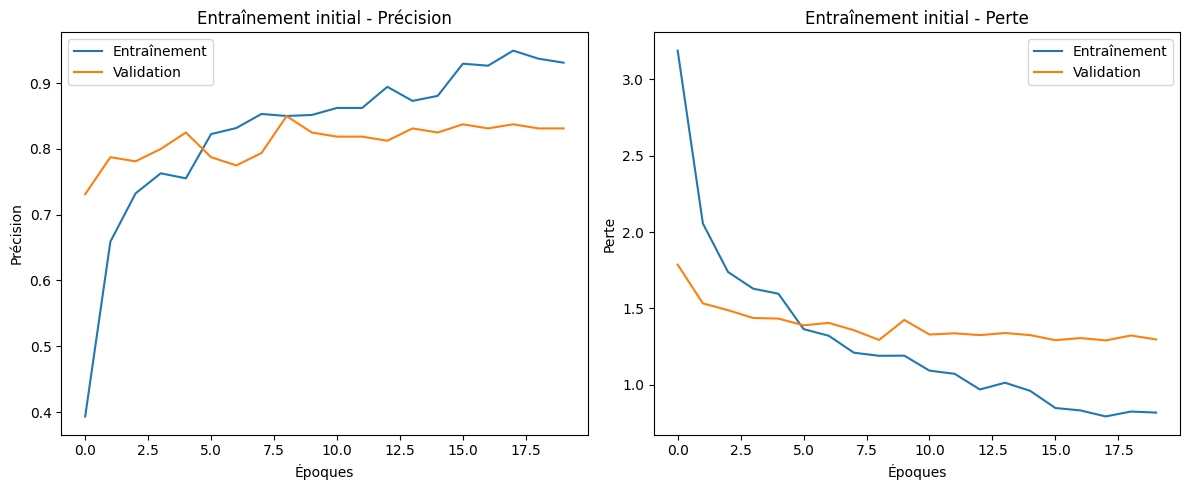

In [ ]:
# Tracer l'historique d'entraînement
def plot_training_history(history, title, save_path):
    plt.figure(figsize=(12, 5))

    # Précision
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Entraînement')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title(f'{title} - Précision')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()

    # Perte
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Entraînement')
    plt.plot(history['val_loss'], label='Validation')
    plt.title(f'{title} - Perte')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Visualiser l'historique d'entraînement initial
plot_training_history(
    history_phase_1,
    'Entraînement initial',
    os.path.join(phase1_visualizations_folder, 'training_history.png')
)

### Interprétation de l'entraînement initial (Phase 1)

* **Progression d'apprentissage solide** : Le modèle a démarré avec une précision de validation de 73,1% à l'époque 1 et a atteint 85% à l'époque 9, montrant une bonne capacité d'adaptation aux données

* **Métriques finales satisfaisantes** : La précision sur l'ensemble de test est de 86,1%, ce qui est un bon résultat pour un modèle de classification d'images à plusieurs classes

* **Signes de surapprentissage modéré** : Écart entre précision d'entraînement (94,3% à l'époque 20) et précision de validation (83,1%), indiquant un certain surapprentissage mais pas excessif

* **Efficacité des mécanismes de régularisation** :
  - La réduction du taux d'apprentissage s'est déclenchée à l'époque 14
  - Restauration des poids de l'époque 18, identifiée comme optimale par l'early stopping
  - Le Dropout inclus dans le modèle a aidé à contenir le surapprentissage

* **Plateau de performance** : La précision de validation a stagné après l'époque 9, suggérant que le modèle a atteint sa capacité maximale dans cette configuration

* **Base solide pour le fine-tuning** : Avec 86,1% de précision sur l'ensemble de test, ce modèle offre une excellente base pour la phase de fine-tuning avec dégel progressif

Ce modèle initial montre un bon équilibre entre capacité d'apprentissage et généralisation, avec un surapprentissage contenu. La phase de fine-tuning progressif pourrait maintenant améliorer subtilement les performances tout en évitant une dégradation due au surapprentissage.

## Images générées par la data augmentation

Avec l'approche que nous utilisons, la data augmentation se fait "à la volée" pendant l'entraînement, ce qui signifie que :

1. **Aucune image n'est stockée en mémoire** : Les images augmentées sont générées dynamiquement pendant l'entraînement et ne sont pas sauvegardées sur le disque.

2. **Nombre théorique d'images** : Le nombre total d'images "vues" par le modèle pendant l'entraînement peut être calculé ainsi :
   ```
   Nombre d'images = nombre d'époques × steps_per_epoch × batch_size
   ```

Dans notre cas, avec :
- 50 époques (maximum)
- 41 steps_per_epoch
- batch_size de 32

Le nombre maximum d'images augmentées serait : 50 × 41 × 32 = 65 600 images.

3. **Variété infinie** : Comme l'augmentation est aléatoire, chaque image originale peut générer une infinité de variations différentes au fil des époques.

In [ ]:
# Visualiser plusieurs exemples d'augmentation d'une même image
def visualize_augmentations(original_image, num_augmentations=9):
    plt.figure(figsize=(12, 12))

    # Afficher l'image originale
    plt.subplot(3, 4, 1)
    plt.imshow(original_image/255.0)  # Normaliser pour l'affichage
    plt.title("Image originale")
    plt.axis('off')

    # Créer un tensor à partir de l'image
    img_tensor = tf.convert_to_tensor(original_image)
    img_tensor = tf.expand_dims(img_tensor, 0)  # Ajouter dimension de batch

    # Générer et afficher plusieurs versions augmentées
    for i in range(num_augmentations):
        # Appliquer l'augmentation (sans le prétraitement final)
        augmented_img, _ = augment_image(img_tensor[0], 0)

        # Annuler le prétraitement pour l'affichage
        display_img = augmented_img.numpy()
        if hasattr(preprocess_input, 'func'):  # Si c'est une fonction partielle
            if preprocess_input.func.__name__ == 'preprocess_input':
                # Pour ResNet50, on ajoute les valeurs RGB moyennes
                display_img = display_img + [123.68, 116.779, 103.939]
                display_img = np.clip(display_img, 0, 255) / 255.0

        # Afficher l'image augmentée
        plt.subplot(3, 4, i+2)
        plt.imshow(display_img)
        plt.title(f"Augmentation {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_folder, 'multiples_augmentations.png'))
    plt.show()

# Choisir une image de l'ensemble d'entraînement
sample_idx = np.random.randint(0, len(X_train))
sample_image = X_train[sample_idx]
sample_label = y_train[sample_idx]
print(f"Visualisation des augmentations pour la catégorie: {label_encoder.inverse_transform([sample_label])[0]}")

# Visualiser plusieurs augmentations de cette image
visualize_augmentations(sample_image)

In [ ]:
# Calculer le nombre réel d'images générées
nb_epochs_completed = len(history.history['accuracy'])
total_images_seen = nb_epochs_completed * steps_per_epoch * batch_size
print(f"Nombre d'époques complétées: {nb_epochs_completed}")
print(f"Nombre total d'images vues pendant l'entraînement: {total_images_seen}")
print(f"Nombre d'images originales dans l'ensemble d'entraînement: {len(X_train)}")
print(f"Facteur de multiplication par data augmentation: {total_images_seen/len(X_train):.2f}x")

Nombre d'époques complétées: 19
Nombre total d'images vues pendant l'entraînement: 12464
Nombre d'images originales dans l'ensemble d'entraînement: 670
Facteur de multiplication par data augmentation: 18.60x


## 🚀 Optimisation par fine-tuning du modèle pré-entraîné (Phase 2)

> L'objectif est d'affiner le modèle préentraîné en adaptant les couches profondes aux spécificités de notre jeu de données
  
* **Approche technique** :
  - Chargement du meilleur modèle de la phase 1 (85,10% de précision sur l'ensemble de test)
  - Dégel de 27,06% des paramètres totaux (6,7 millions de paramètres)
  - Combinaison des couches personnalisées et des couches profondes du ResNet50
  - Utilisation d'un taux d'apprentissage très faible (0,00005)

* **Avantages attendus** :
  - Meilleure adaptation aux caractéristiques spécifiques des produits de marketplace
  - Amélioration potentielle de la précision de classification
  - Conservation des connaissances générales utiles du préentraînement
  
* **Mécanismes de protection** :
  - Taux d'apprentissage réduit pour éviter de détruire les caractéristiques apprises
  - Early stopping avec patience de 8 époques
  - Réduction automatique du taux d'apprentissage en cas de plateau
  - Sauvegarde des meilleurs poids pour éviter le surapprentissage

* **Paramètres d'entraînement** :
  - 30 époques maximum (avec arrêt précoce)
  - Batch size de 16 images
  - Continuation de l'augmentation de données comme en phase 1
  - Évaluation régulière sur l'ensemble de validation

In [ ]:
# Définir les chemins pour la phase 2
phase2_folder = os.path.join(run_folder, "phase2_finetuning")
phase2_models_folder = os.path.join(phase2_folder, "models")
phase2_logs_folder = os.path.join(phase2_folder, "logs")
phase2_visualizations_folder = os.path.join(phase2_folder, "visualizations")

In [ ]:
# Charger le meilleur modèle de la phase 1
best_model_path = os.path.join(phase1_folder, "models", "best_model.keras")
model = tf.keras.models.load_model(best_model_path)

# Récupérer toutes les couches du modèle
all_layers = model.layers
print(f"Nombre total de couches: {len(all_layers)}")

# Identifier les couches personnalisées ajoutées après ResNet50
custom_top_layers = 6  # GlobalAveragePooling2D + Dense + Dropout + Dense + Dropout + Dense
base_layers_count = len(all_layers) - custom_top_layers

# Par défaut, on gèle toutes les couches
for layer in model.layers:
    layer.trainable = False

# Dégeler les couches personnalisées ajoutées (les 6 dernières)
for i in range(base_layers_count, len(all_layers)):
    model.layers[i].trainable = True
    print(f"Couche personnalisée dégelée: {model.layers[i].name}")

# Dégeler les couches profondes du modèle de base
num_base_layers_to_unfreeze = 10
start_idx = base_layers_count - num_base_layers_to_unfreeze
end_idx = base_layers_count

print("\nDégel des couches profondes du modèle de base:")
for i in range(start_idx, end_idx):
    model.layers[i].trainable = True
    print(f"Couche dégelée: {model.layers[i].name}")

total_unfrozen = num_base_layers_to_unfreeze + custom_top_layers
print(f"\nTotal de couches dégelées: {total_unfrozen}")

# start_layer_idx = base_layers_count - 10  # Commencer à partir des 10 dernières couches du base model
# end_layer_idx = base_layers_count - 1     # Jusqu'à la dernière couche du base model

# print(f"\nCouches personnalisées dégelées: {custom_top_layers}")
# print(f"Couches de base qui seront dégelées progressivement: {end_layer_idx - start_layer_idx + 1}")

Nombre total de couches: 181
Couche personnalisée dégelée: global_average_pooling2d_7
Couche personnalisée dégelée: dense_17
Couche personnalisée dégelée: dropout_10
Couche personnalisée dégelée: dense_18
Couche personnalisée dégelée: dropout_11
Couche personnalisée dégelée: dense_19

Dégel des couches profondes du modèle de base:
Couche dégelée: conv5_block3_1_conv
Couche dégelée: conv5_block3_1_bn
Couche dégelée: conv5_block3_1_relu
Couche dégelée: conv5_block3_2_conv
Couche dégelée: conv5_block3_2_bn
Couche dégelée: conv5_block3_2_relu
Couche dégelée: conv5_block3_3_conv
Couche dégelée: conv5_block3_3_bn
Couche dégelée: conv5_block3_add
Couche dégelée: conv5_block3_out

Total de couches dégelées: 16


In [ ]:
from tensorflow.keras import backend as K

# Afficher un résumé des paramètres entraînables vs non-entraînables
trainable_params = sum(K.count_params(w) for w in model.trainable_weights)
non_trainable_params = sum(K.count_params(w) for w in model.non_trainable_weights)
total_params = trainable_params + non_trainable_params

print("\n" + "="*50)
print("RÉSUMÉ DES PARAMÈTRES DU MODÈLE (PHASE 2)")
print("="*50)
print(f"Paramètres entraînables: {trainable_params:,}")
print(f"Paramètres non-entraînables: {non_trainable_params:,}")
print(f"Paramètres totaux: {total_params:,}")
print(f"Pourcentage de paramètres entraînables: {trainable_params/total_params*100:.2f}%")
print("="*50 + "\n")


RÉSUMÉ DES PARAMÈTRES DU MODÈLE (PHASE 2)
Paramètres entraînables: 5,647,879
Paramètres non-entraînables: 19,122,048
Paramètres totaux: 24,769,927
Pourcentage de paramètres entraînables: 22.80%



In [ ]:
# ======================================================
# PHASE 2: FINE-TUNING AVEC DÉGEL DE COUCHES
# ======================================================

print("="*50)
print("PHASE 2: FINE-TUNING")
print("="*50)

# Configurer les callbacks pour la phase 2
checkpoint = ModelCheckpoint(
    os.path.join(phase2_models_folder, 'best_model_phase2.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

tensorboard = TensorBoard(
    log_dir=phase2_logs_folder,
    histogram_freq=1,
    write_graph=True
)

class GPUUtilizationCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if tf.config.list_physical_devices('GPU'):
            print(f"\nÉpoque {epoch+1}: Vérification de l'utilisation GPU (phase 2)")

callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard, GPUUtilizationCallback()]

# Recompiler le modèle avec un taux d'apprentissage très faible pour le fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002)  # 0.00005 → 0.00002

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Préparer les datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Configurer les datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 24  # 16 → 24

train_ds = train_ds.shuffle(buffer_size=len(X_train))
train_ds = train_ds.map(augment_image_for_training, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(AUTOTUNE)
train_ds = train_ds.repeat()  # Répéter indéfiniment

val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(AUTOTUNE)
val_ds = val_ds.repeat()  # Répéter indéfiniment

test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(AUTOTUNE)

# Calculer steps_per_epoch et validation_steps
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

print(f"Nombre de pas d'entraînement par époque (phase 2): {steps_per_epoch}")
print(f"Nombre de pas de validation par époque (phase 2): {validation_steps}")

# Entraîner le modèle (fine-tuning)
try:
    print("\nDémarrage du fine-tuning...")
    history = model.fit(
        train_ds,
        epochs=30,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )

    print("Fine-tuning terminé avec succès!")

    # Évaluer le modèle sur l'ensemble de test
    test_loss, test_accuracy = model.evaluate(test_ds, steps=len(X_test) // batch_size)
    print(f"Précision sur l'ensemble de test (phase 2): {test_accuracy:.4f}")

    # Sauvegarder le modèle final
    model.save(os.path.join(phase2_models_folder, 'final_model_phase2.keras'))
    model.save_weights(os.path.join(phase2_models_folder, 'final_model_phase2.weights.h5'))

    # Sauvegarder l'historique
    history_dict = {
        'accuracy': [float(val) for val in history.history['accuracy']],
        'val_accuracy': [float(val) for val in history.history['val_accuracy']],
        'loss': [float(val) for val in history.history['loss']],
        'val_loss': [float(val) for val in history.history['val_loss']],
        'lr': [float(val) for val in history.history['learning_rate']]
    }

    with open(os.path.join(phase2_models_folder, 'training_history_phase2.json'), 'w') as f:
        json.dump(history_dict, f)

    print("="*50)
    print("PHASE 2 TERMINÉE")
    print(f"Le meilleur modèle est sauvegardé dans {phase2_models_folder}")
    print("="*50)

except Exception as e:
    print(f"Erreur pendant le fine-tuning: {e}")

PHASE 2: FINE-TUNING
Nombre de pas d'entraînement par époque (phase 2): 27
Nombre de pas de validation par époque (phase 2): 7

Démarrage du fine-tuning...
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8484 - loss: 1.1131
Epoch 1: val_accuracy improved from -inf to 0.84524, saving model to /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/train/run_20250502_091252/phase2_finetuning/models/best_model_phase2.keras

Époque 1: Vérification de l'utilisation GPU (phase 2)
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 820ms/step - accuracy: 0.8484 - loss: 1.1140 - val_accuracy: 0.8452 - val_loss: 1.2876 - learning_rate: 2.0000e-05
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8770 - loss: 1.0851
Epoch 2: val_accuracy improved from 0.84524 to 0.85119, saving model to /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/train/run_20250502_091252/phase2_finetuning/models/best_mod

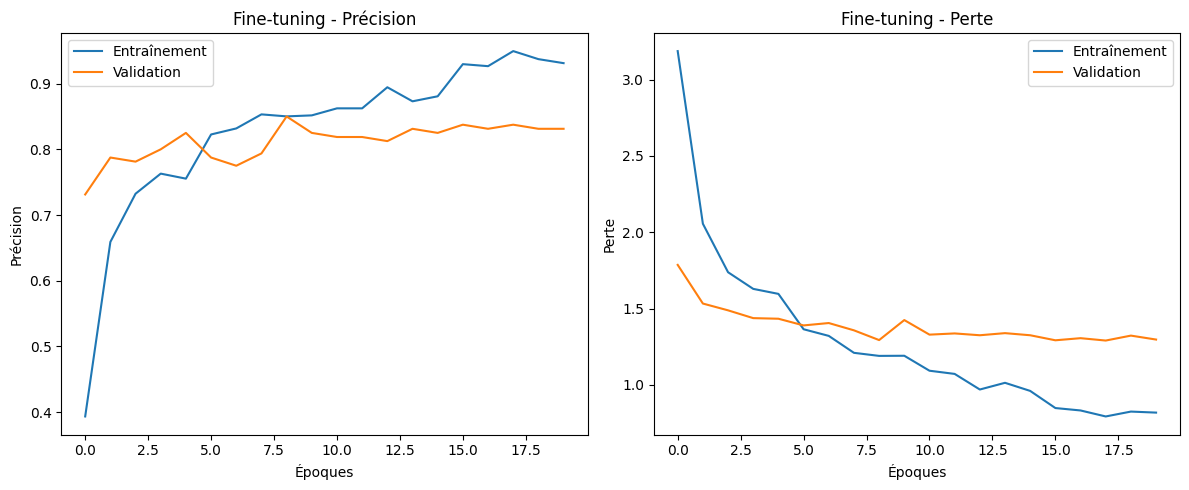

In [ ]:
history_phase_2_path = os.path.join(phase2_models_folder, 'training_history_phase2.json')
with open(history_phase_1_path, 'r') as f:
    history_phase_2 = json.load(f)


# Visualiser l'historique de fine-tuning
plot_training_history(
    history_phase_2,
    'Fine-tuning',
    os.path.join(phase2_visualizations_folder, 'fine_tuning_history.png')
)

### Interprétation du fine-tuning (Phase 2)

* **Amélioration des performances** : La précision sur l'ensemble de test est passée de 86,06% (phase 1) à 86,46% (phase 2), montrant un gain modeste de 0,4 point

* **Convergence rapide** : Le modèle a atteint sa meilleure précision de validation (85,12%) dès l'époque 2, indiquant que les couches ajustées se sont adaptées rapidement

* **Surapprentissage progressif** : Écart croissant entre précision d'entraînement (atteignant 96,23% à l'époque 16) et précision de validation (plafonnant à 85,12%), révélant un surapprentissage

* **Efficacité des mécanismes de régularisation** :
  - Réduction du taux d'apprentissage aux époques 16 et 20
  - Arrêt précoce à l'époque 20 avec restauration des poids de l'époque 12
  - Ces mécanismes ont permis d'éviter que le surapprentissage ne dégrade les performances

* **Stratégie d'entraînement appropriée** : L'utilisation d'un taux d'apprentissage très faible (2e-5) a permis d'adapter subtilement les couches dégelées sans perdre les connaissances préacquises

* **Gains modestes mais réels** : Malgré l'ampleur limitée de l'amélioration, celle-ci confirme la valeur du fine-tuning pour affiner le modèle

Cette phase de fine-tuning a apporté une amélioration légère mais constante, démontrant l'intérêt de cette approche tout en soulignant l'importance des mécanismes de régularisation pour contrôler le surapprentissage.

## Chargement des modèles

In [ ]:
# Définir les chemins vers les modèles
phase1_model_path = os.path.join(phase1_folder, "models", "best_model.keras")
phase2_model_path = os.path.join(phase2_folder, "models", "best_model_phase2.keras")

# Charger les modèles
phase1_model = tf.keras.models.load_model(phase1_model_path)
phase2_model = None  # Initialiser à None au cas où le chargement échoue

# Essayer de charger le modèle de phase 2 s'il existe
try:
    phase2_model = tf.keras.models.load_model(phase2_model_path)
    print("Modèles des phases 1 et 2 chargés avec succès.")
except:
    print("Le modèle de phase 2 n'a pas pu être chargé. Seul le modèle de phase 1 est disponible.")

# Vérifier les modèles chargés
print("\nRésumé du modèle de phase 1:")
phase1_model.summary()

if phase2_model is not None:
    print("\nRésumé du modèle de phase 2:")
    phase2_model.summary()

Modèles des phases 1 et 2 chargés avec succès.

Résumé du modèle de phase 1:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 27,134,359 (103.51 MB)

 Trainable params: 1,182,215 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2,364,432 (9.02 MB)


Résumé du modèle de phase 2:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 36,065,687 (137.58 MB)

 Trainable params: 5,647,879 (21.54 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 11,295,760 (43.09 MB)

## Évaluation du modèle des performances du modèle

Nous procédons à une évaluation complète et rigoureuse de notre modèle de classification sur l'ensemble de test, fournissant une vision détaillée de ses performances réelles :

- **Métriques multidimensionnelles** : Nous calculons un ensemble de métriques (précision, rappel, score F1) pour évaluer la performance globale et par classe de notre modèle.
- **Analyse visuelle** : Nous générons une matrice de confusion sous forme de carte thermique, permettant d'identifier rapidement les forces et faiblesses du modèle pour chaque catégorie de produits.
- **Documentation exhaustive** : Nous sauvegardons tous les résultats d'analyse dans des fichiers texte et des visualisations pour faciliter leur intégration dans notre rapport final.
- **Interprétation des résultats** : Cette analyse nous permet d'évaluer objectivement si notre modèle répond aux exigences de l'entreprise et d'identifier les catégories nécessitant potentiellement des améliorations.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import json
import pandas as pd

def evaluate_model(model, test_ds, metrics_folder, model_name, num_classes=5):
    """
    Évalue un modèle et sauvegarde les métriques dans le dossier spécifié.

    Args:
        model: Le modèle TensorFlow à évaluer
        test_ds: Dataset de test
        metrics_folder: Dossier où sauvegarder les métriques
        model_name: Nom du modèle pour les fichiers sauvegardés
        num_classes: Nombre de classes de classification
    """

    # Créer le dossier si nécessaire
    os.makedirs(metrics_folder, exist_ok=True)

    # Extraire les données de test
    X_test_extracted = []
    y_test_extracted = []

    # Extraire les données du dataset TensorFlow
    for images, labels in test_ds.unbatch():
        X_test_extracted.append(images.numpy())
        y_test_extracted.append(labels.numpy())

    X_test_extracted = np.array(X_test_extracted)
    y_test_extracted = np.array(y_test_extracted)

    # Prédictions
    y_pred_proba = model.predict(test_ds)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Obtenir la liste des classes
    try:
        class_names = list(label_encoder.classes_)
    except:
        class_names = [f"Classe {i}" for i in range(num_classes)]

    # 1. Rapport de classification
    class_report = classification_report(y_test_extracted, y_pred, target_names=class_names, output_dict=True)

    # Sauvegarder le rapport au format JSON
    with open(os.path.join(metrics_folder, f'{model_name}_classification_report.json'), 'w') as f:
        json.dump(class_report, f, indent=4)

    # Sauvegarder aussi en CSV plus lisible
    df_report = pd.DataFrame(class_report).transpose()
    df_report.to_csv(os.path.join(metrics_folder, f'{model_name}_classification_report.csv'))

    print("Rapport de classification :")
    print(df_report)
    print()

    # 2. Métriques principales
    accuracy = accuracy_score(y_test_extracted, y_pred)
    precision = precision_score(y_test_extracted, y_pred, average='weighted')
    recall = recall_score(y_test_extracted, y_pred, average='weighted')
    f1 = f1_score(y_test_extracted, y_pred, average='weighted')

    metrics = {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1)
    }

    # Sauvegarder les métriques au format JSON
    with open(os.path.join(metrics_folder, f'{model_name}_metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=4)

    # 3. Matrice de confusion
    cm = confusion_matrix(y_test_extracted, y_pred)

    # Visualisation de la matrice de confusion
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies classes')
    plt.title(f'Matrice de confusion - {model_name}')
    plt.tight_layout()

    # Sauvegarder la matrice de confusion
    plt.savefig(os.path.join(metrics_folder, f'{model_name}_confusion_matrix.png'), dpi=300)

    # 4. Visualisation des métriques par classe
    metrics_by_class = {
        'precision': [class_report[cls]['precision'] for cls in class_names],
        'recall': [class_report[cls]['recall'] for cls in class_names],
        'f1-score': [class_report[cls]['f1-score'] for cls in class_names],
        'support': [class_report[cls]['support'] for cls in class_names]
    }

    # Créer un DataFrame pour faciliter la visualisation
    df_metrics = pd.DataFrame(metrics_by_class, index=class_names)
    df_metrics.to_csv(os.path.join(metrics_folder, f'{model_name}_metrics_by_class.csv'))

    # Visualisation des métriques par classe
    fig, ax = plt.subplots(figsize=(12, 8))
    df_metrics[['precision', 'recall', 'f1-score']].plot(kind='bar', ax=ax)
    plt.title(f'Métriques par classe - {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Sauvegarder le graphique
    plt.savefig(os.path.join(metrics_folder, f'{model_name}_metrics_by_class.png'), dpi=300)

    # Afficher un résumé
    print(f"\nÉvaluation du modèle {model_name} terminée :")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Toutes les métriques ont été sauvegardées dans {metrics_folder}")

    return metrics

### Évaluer le modèle de l'entraînement initial (phase 1)

Évaluation du modèle de la phase 1...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Rapport de classification :
                            precision    recall  f1-score     support
Baby Care                    0.880000  0.733333  0.800000   30.000000
Beauty and Personal Care     0.880000  0.733333  0.800000   30.000000
Computers                    0.928571  0.866667  0.896552   30.000000
Home Decor & Festive Needs   0.857143  0.800000  0.827586   30.000000
Home Furnishing              0.823529  0.933333  0.875000   30.000000
Kitchen & Dining             0.742857  0.866667  0.800000   30.000000
Watches                      0.857143  1.000000  0.923077   30.000000
accuracy                     0.847619  0.847619  0.847619    0.847619
macro avg                    0.852749  0.847619  0.846031  210.000000
weighted avg                 0.852749  0.847619  0.846031  210.000000


Évaluation du modèle phase1_standard terminée :
Accuracy: 0.8476
Precision: 0.8527
Recall: 0.8476
F1-score: 0.8460
Toutes le

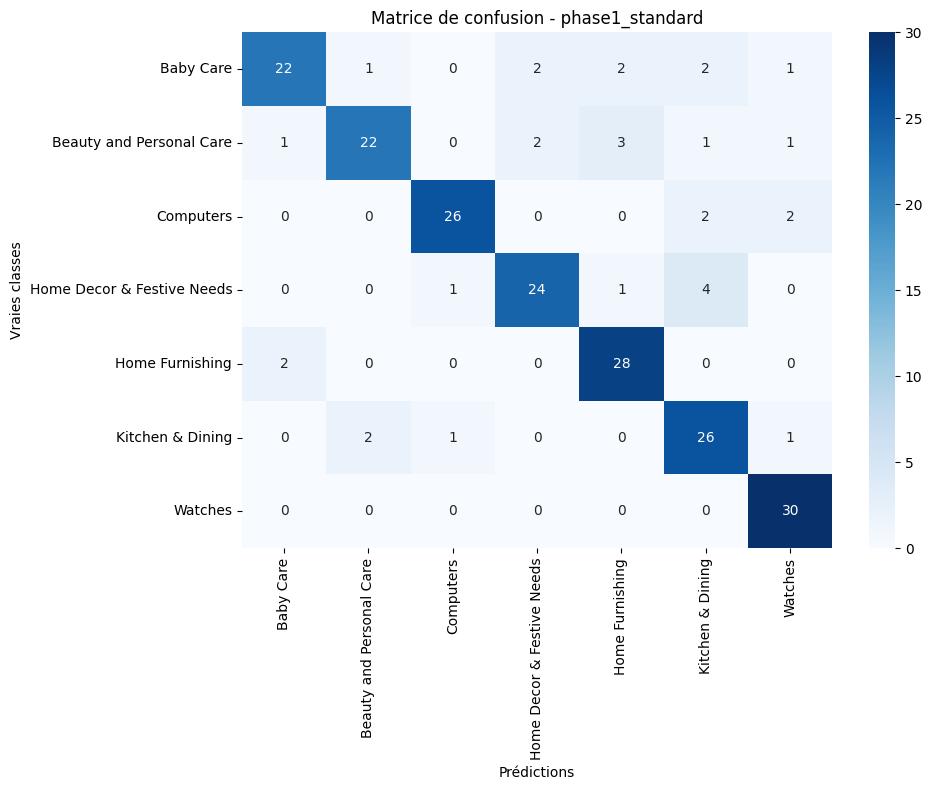

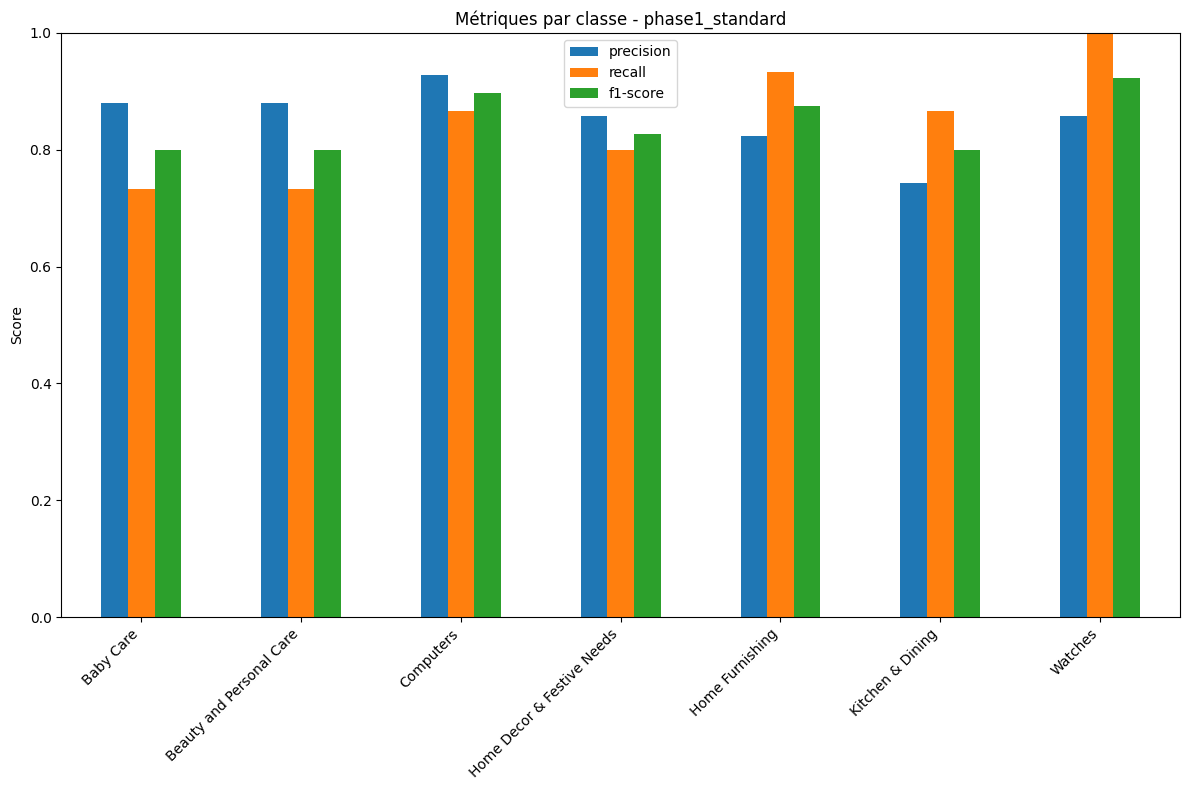

In [ ]:
# Évaluer le modèle de la phase 1
print("Évaluation du modèle de la phase 1...")
phase1_metrics = evaluate_model(
    model=phase1_model,
    test_ds=test_ds,
    metrics_folder=phase1_metrics_folder,
    model_name="phase1_standard",
    num_classes=len(label_encoder.classes_)
)

### Évaluer le modèle du fine-tuning (phase 2)


Évaluation du modèle de la phase 2...
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 689ms/step
Rapport de classification :
                            precision    recall  f1-score     support
Baby Care                    0.857143  0.800000  0.827586   30.000000
Beauty and Personal Care     0.913043  0.700000  0.792453   30.000000
Computers                    0.928571  0.866667  0.896552   30.000000
Home Decor & Festive Needs   0.888889  0.800000  0.842105   30.000000
Home Furnishing              0.848485  0.933333  0.888889   30.000000
Kitchen & Dining             0.729730  0.900000  0.805970   30.000000
Watches                      0.882353  1.000000  0.937500   30.000000
accuracy                     0.857143  0.857143  0.857143    0.857143
macro avg                    0.864031  0.857143  0.855865  210.000000
weighted avg                 0.864031  0.857143  0.855865  210.000000


Évaluation du modèle phase2_finetuning terminée :
Accuracy: 0.8571
Precision: 0.8640
Recall: 0.8571
F1-score: 0.8559
Toute

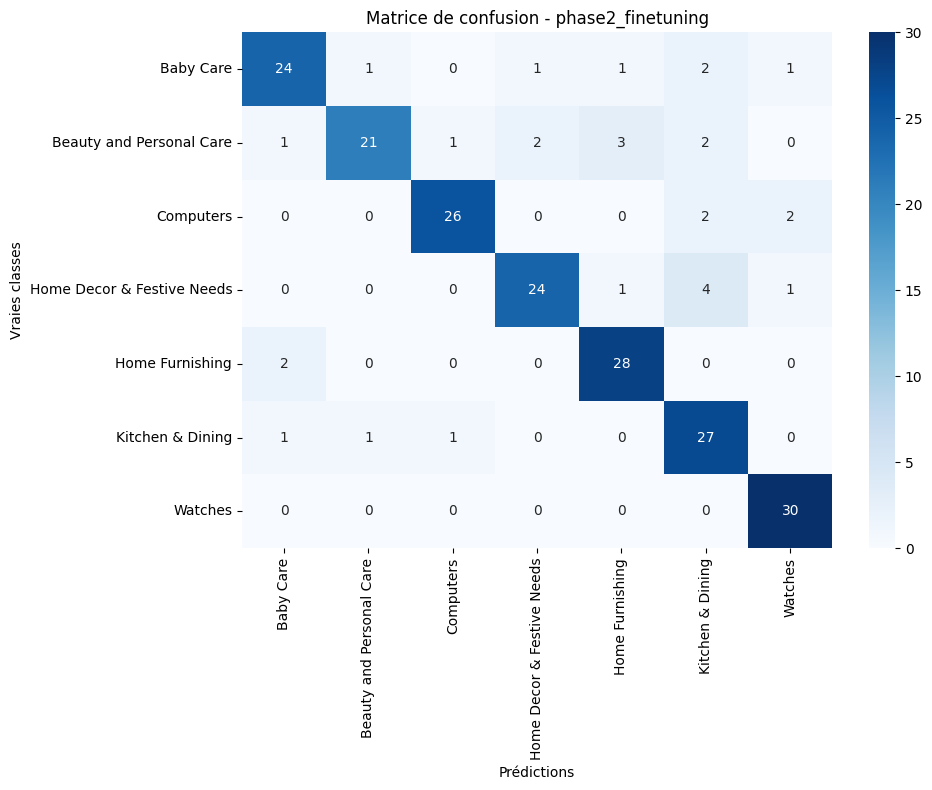

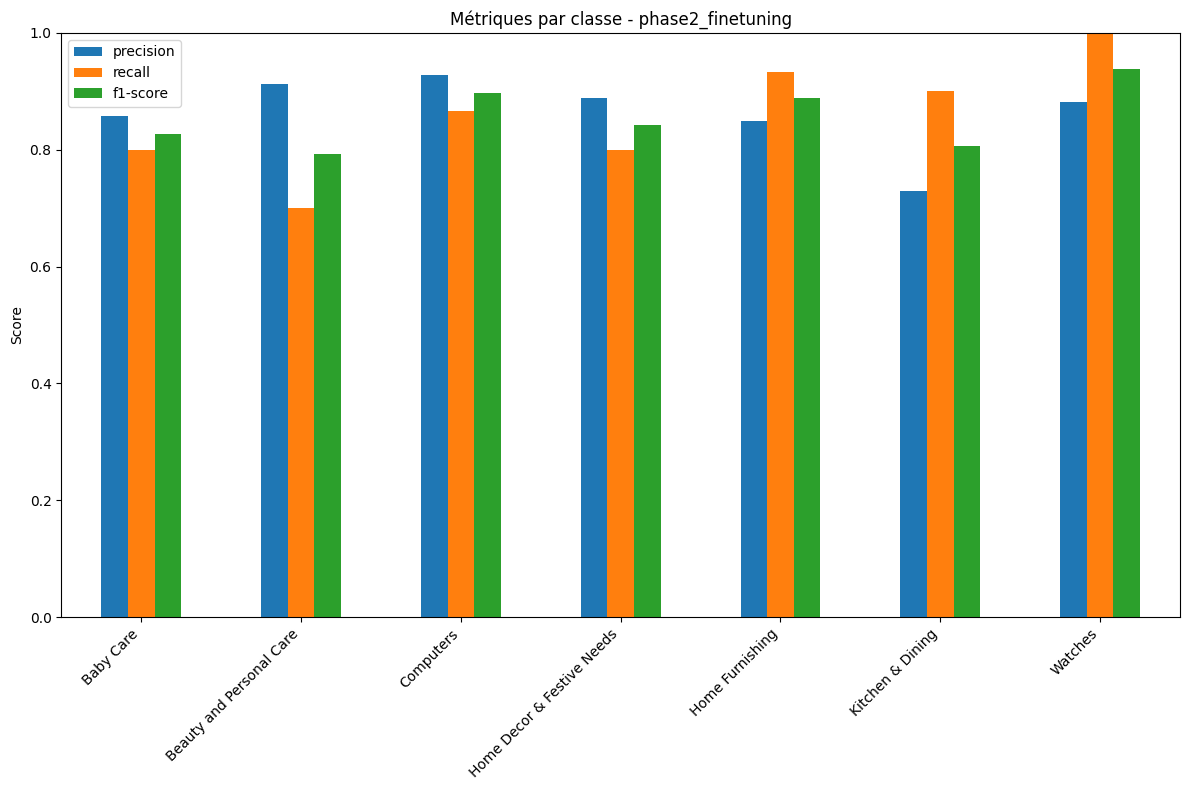

In [ ]:
print("\nÉvaluation du modèle de la phase 2...")
phase2_metrics = evaluate_model(
    model=phase2_model,
    test_ds=test_ds,
    metrics_folder=phase2_metrics_folder,
    model_name="phase2_finetuning",
    num_classes=len(label_encoder.classes_)
)

## Visualisation des prédictions

In [ ]:
def visualize_predictions(model, X, y_true, class_names, visualization_folder, filename_prefix='predictions', num_examples=9):
    """
    Visualise les prédictions d'un modèle sur un ensemble d'exemples aléatoires.

    Args:
        model: Le modèle à utiliser pour les prédictions
        X: Les images à prédire
        y_true: Les vraies étiquettes
        class_names: Les noms des classes
        visualization_folder: Dossier où sauvegarder les visualisations
        filename_prefix: Préfixe pour le nom du fichier sauvegardé
        num_examples: Nombre d'exemples à visualiser
    """

    # Assurez-vous que le dossier existe
    os.makedirs(visualization_folder, exist_ok=True)

    # Convertir X en batch pour la prédiction si ce n'est pas déjà fait
    if len(X.shape) == 3:  # Si X est une seule image
        X_batch = np.expand_dims(X, axis=0)
    else:
        X_batch = X

    # Faire les prédictions
    y_pred_proba = model.predict(X_batch)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Choisir des indices aléatoires
    indices = np.random.choice(range(len(X)), min(num_examples, len(X)), replace=False)

    # Créer la figure
    rows = int(np.ceil(np.sqrt(num_examples)))
    cols = int(np.ceil(num_examples / rows))

    plt.figure(figsize=(cols * 4, rows * 3.5))
    for i, idx in enumerate(indices):
        if i >= num_examples:
            break

        plt.subplot(rows, cols, i + 1)

        # Afficher l'image d'origine (sans prétraitement)
        img = X[idx]
        # Normaliser pour l'affichage
        if img.max() > 1:
            img_display = img / 255.0
        else:
            img_display = img

        plt.imshow(img_display)

        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]

        # Ajouter la probabilité de prédiction
        pred_confidence = y_pred_proba[idx][y_pred[idx]]

        # Définir la couleur en fonction de la précision
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"Vrai: {true_label}\nPréd: {pred_label}\nConf: {pred_confidence:.2f}",
                 color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()

    # Sauvegarder l'image
    save_path = os.path.join(visualization_folder, f'{filename_prefix}_examples.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    print(f"Visualisation sauvegardée dans {save_path}")
    plt.show()
    print()

    # Également visualiser quelques exemples mal classés, s'il y en a
    misclassified_indices = np.where(y_pred != y_true)[0]

    if len(misclassified_indices) > 0:
        # Limiter à 9 exemples maximum pour les erreurs
        num_errors = min(9, len(misclassified_indices))
        error_indices = np.random.choice(misclassified_indices, num_errors, replace=False)

        # Créer la figure pour les erreurs
        error_rows = int(np.ceil(np.sqrt(num_errors)))
        error_cols = int(np.ceil(num_errors / error_rows))

        plt.figure(figsize=(error_cols * 4, error_rows * 3.5))
        for i, idx in enumerate(error_indices):
            plt.subplot(error_rows, error_cols, i + 1)

            # Afficher l'image
            img = X[idx]
            if img.max() > 1:
                img_display = img / 255.0
            else:
                img_display = img

            plt.imshow(img_display)

            true_label = class_names[y_true[idx]]
            pred_label = class_names[y_pred[idx]]
            pred_confidence = y_pred_proba[idx][y_pred[idx]]

            plt.title(f"Vrai: {true_label}\nPréd: {pred_label}\nConf: {pred_confidence:.2f}",
                     color='red', fontsize=10)
            plt.axis('off')

        plt.tight_layout()

        # Sauvegarder l'image des erreurs
        error_save_path = os.path.join(visualization_folder, f'{filename_prefix}_errors.png')
        plt.savefig(error_save_path, dpi=300, bbox_inches='tight')

        print(f"Visualisation des erreurs sauvegardée dans {error_save_path}")
        plt.show()
    else:
        print("Aucune erreur de classification trouvée dans l'échantillon!")

### Visualisation des prédictions du modèle de la phase 1

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 738ms/step
Visualisation sauvegardée dans /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/train/run_20250502_091252/phase1_standard/visualizations/phase1_examples.png


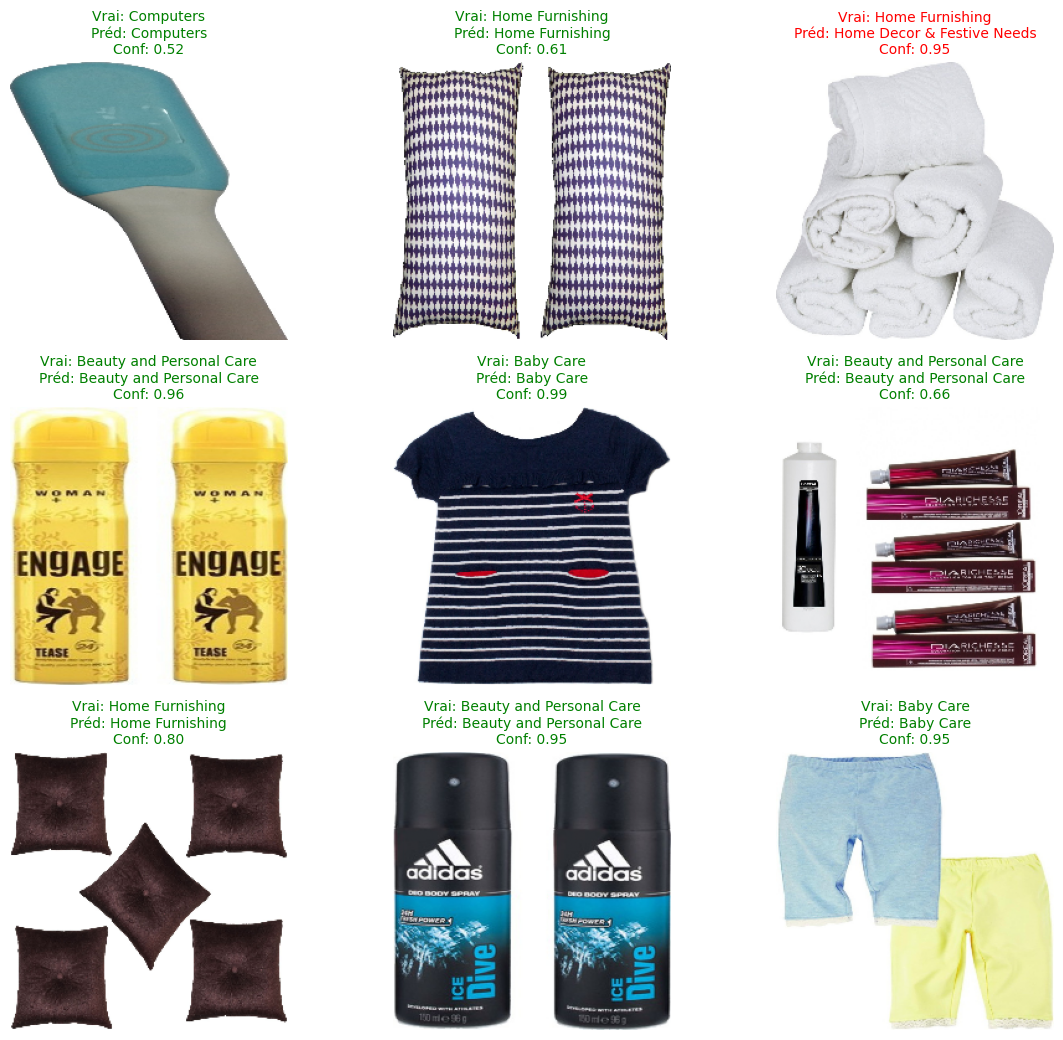

Visualisation des erreurs sauvegardée dans /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/train/run_20250502_091252/phase1_standard/visualizations/phase1_errors.png


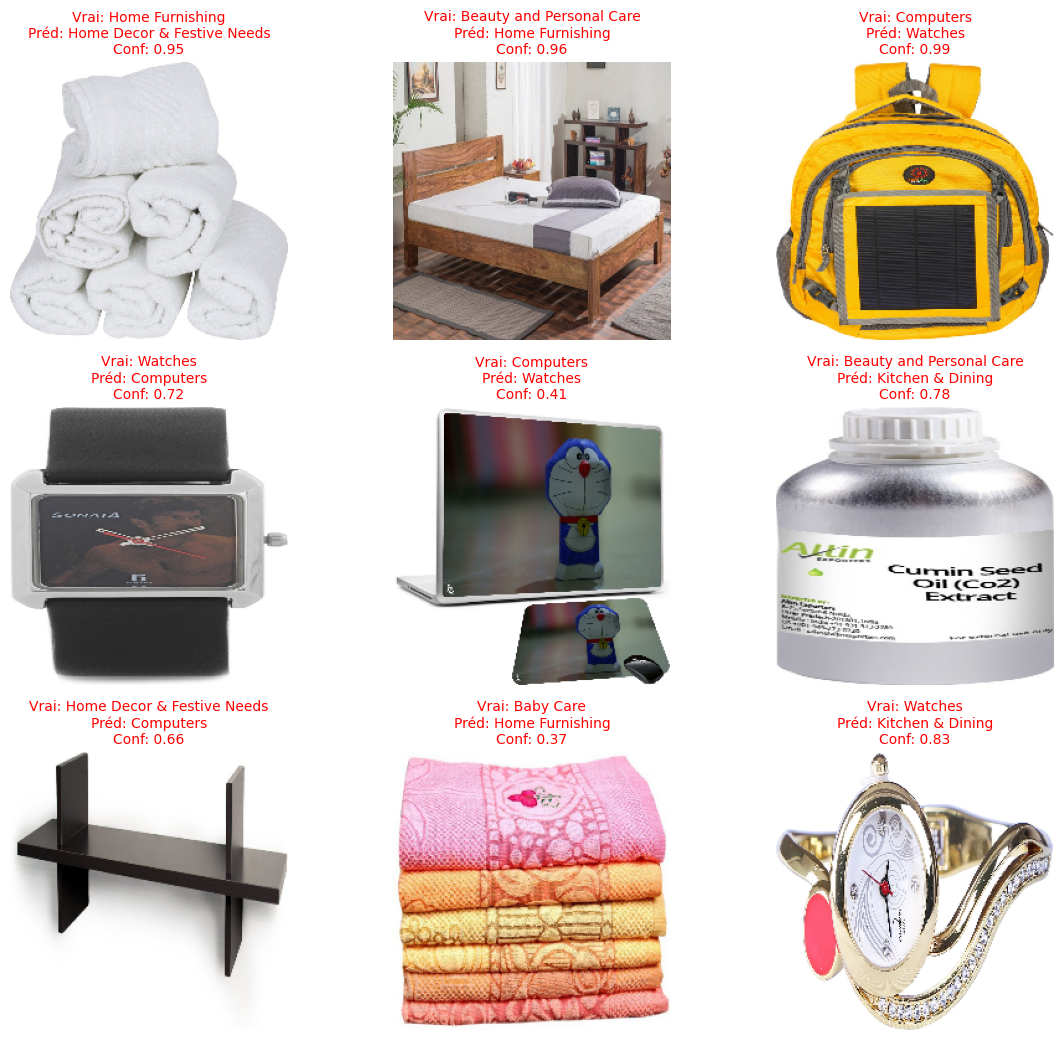

In [ ]:
# Visualiser les prédictions du modèle de la phase 1
visualize_predictions(
    model=phase1_model,
    X=X_test,
    y_true=y_test,
    class_names=label_encoder.classes_,
    visualization_folder=phase1_visualizations_folder,
    filename_prefix='phase1'
)

### Visualisation des prédictions du modèle de la phase 2

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 705ms/step
Visualisation sauvegardée dans /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/train/run_20250502_091252/phase2_finetuning/visualizations/phase2_examples.png


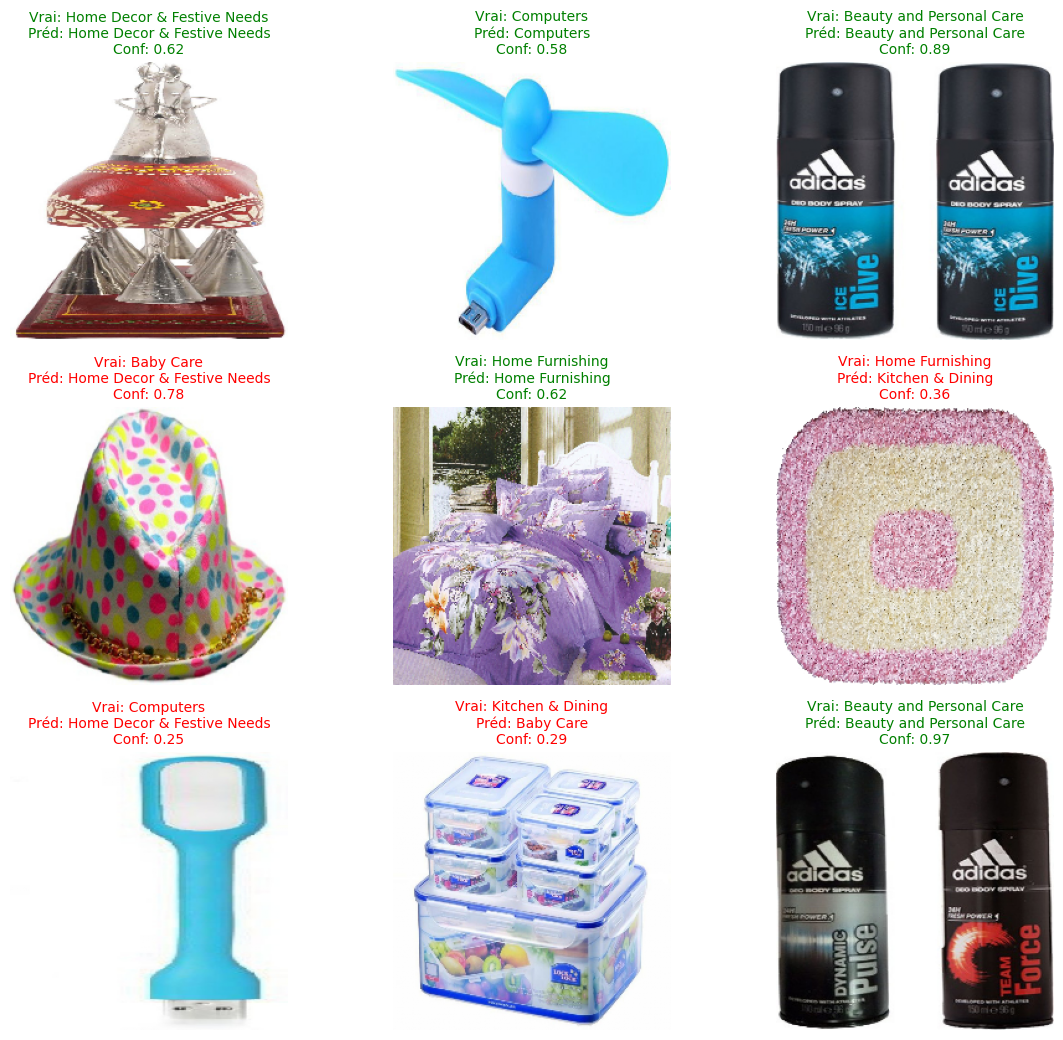


Visualisation des erreurs sauvegardée dans /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/train/run_20250502_091252/phase2_finetuning/visualizations/phase2_errors.png


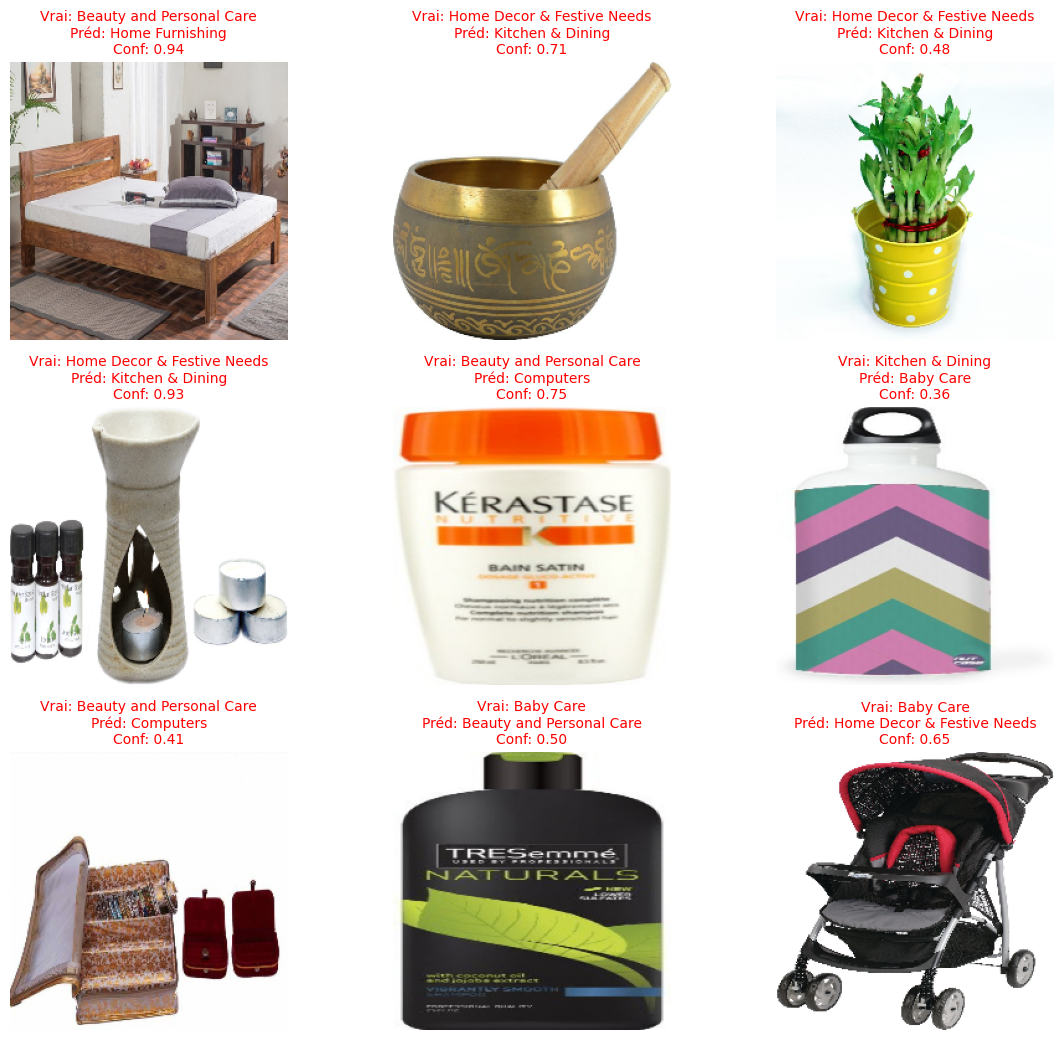

In [ ]:
# Visualiser les prédictions du modèle de la phase 2
visualize_predictions(
    model=phase2_model,
    X=X_test,
    y_true=y_test,
    class_names=label_encoder.classes_,
    visualization_folder=phase2_visualizations_folder,
    filename_prefix='phase2'
)

##  Comparaison de l'entraînement initial et du fine-tuning

In [ ]:
def create_models_comparison_dataframe(phase1_model, phase2_model, test_ds, run_folder,
                                      phase1_history, phase2_history=None):
    """
    Crée un dataframe comparant les métriques des modèles des phases 1 et 2.

    Args:
        phase1_model: Le modèle de la phase 1
        phase2_model: Le modèle de la phase 2 (peut être None)
        test_ds: Dataset de test
        run_folder: Dossier de l'exécution pour sauvegarder le CSV
        phase1_history: Historique d'entraînement de la phase 1
        phase2_history: Historique d'entraînement de la phase 2 (peut être None)
    """

    # Extraire les données de test
    X_test_list = []
    y_test_list = []

    for images, labels in test_ds.unbatch():
        X_test_list.append(images.numpy())
        y_test_list.append(labels.numpy())

    X_test_np = np.array(X_test_list)
    y_test_np = np.array(y_test_list)

    # Initialiser le dataframe
    data = []

    # Évaluer le modèle de la phase 1
    y_pred_phase1 = np.argmax(phase1_model.predict(test_ds), axis=1)

    # Calculer les métriques pour la phase 1
    phase1_data = {
        'run_name': run_folder.split('/')[-1],
        'model': 'phase1_standard',
        'test_accuracy': accuracy_score(y_test_np, y_pred_phase1),
        'test_precision': precision_score(y_test_np, y_pred_phase1, average='weighted'),
        'test_recall': recall_score(y_test_np, y_pred_phase1, average='weighted'),
        'test_f1': f1_score(y_test_np, y_pred_phase1, average='weighted'),
        'num_classes': len(np.unique(y_test_np)),
        'num_train_samples': len(X_train),
        'num_val_samples': len(X_val),
        'num_test_samples': len(X_test_np),
        'final_train_accuracy': phase1_history.history['accuracy'][-1],
        'final_val_accuracy': phase1_history.history['val_accuracy'][-1],
        'final_train_loss': phase1_history.history['loss'][-1],
        'final_val_loss': phase1_history.history['val_loss'][-1]
    }
    data.append(phase1_data)

    # Évaluer le modèle de la phase 2 s'il est disponible
    if phase2_model is not None and phase2_history is not None:
        y_pred_phase2 = np.argmax(phase2_model.predict(test_ds), axis=1)

        # Calculer les métriques pour la phase 2
        phase2_data = {
            'run_name': run_folder.split('/')[-1],
            'model': 'phase2_finetuning',
            'test_accuracy': accuracy_score(y_test_np, y_pred_phase2),
            'test_precision': precision_score(y_test_np, y_pred_phase2, average='weighted'),
            'test_recall': recall_score(y_test_np, y_pred_phase2, average='weighted'),
            'test_f1': f1_score(y_test_np, y_pred_phase2, average='weighted'),
            'num_classes': len(np.unique(y_test_np)),
            'num_train_samples': len(X_train),
            'num_val_samples': len(X_val),
            'num_test_samples': len(X_test_np),
            'final_train_accuracy': phase2_history.history['accuracy'][-1],
            'final_val_accuracy': phase2_history.history['val_accuracy'][-1],
            'final_train_loss': phase2_history.history['loss'][-1],
            'final_val_loss': phase2_history.history['val_loss'][-1]
        }
        data.append(phase2_data)

    # Créer le dataframe
    df = pd.DataFrame(data)

    # Sauvegarder au format CSV
    csv_path = os.path.join(run_folder, 'models_comparison.csv')
    df.to_csv(csv_path, index=False)

    print(f"Comparaison des modèles sauvegardée dans {csv_path}")

    return df

In [ ]:
# Charger les historiques d'entraînement
try:
    # Charger l'historique de la phase 1
    with open(os.path.join(phase1_models_folder, 'training_history_phase1.json'), 'r') as f:
        phase1_history_dict = json.load(f)

    # Convertir en objet similaire à l'historique de Keras
    class HistoryObject:
        def __init__(self, history_dict):
            self.history = history_dict

    phase1_history = HistoryObject(phase1_history_dict)

    # Essayer de charger l'historique de la phase 2
    phase2_history = None
    try:
        with open(os.path.join(phase2_models_folder, 'training_history_phase2.json'), 'r') as f:
            phase2_history_dict = json.load(f)
        phase2_history = HistoryObject(phase2_history_dict)
    except:
        print("Historique de la phase 2 non disponible.")

    # Créer le dataframe de comparaison
    comparison_df = create_models_comparison_dataframe(
        phase1_model=phase1_model,
        phase2_model=phase2_model,
        test_ds=test_ds,
        run_folder=run_folder,
        phase1_history=phase1_history,
        phase2_history=phase2_history
    )

except Exception as e:
    print(f"Erreur lors de la création du dataframe de comparaison: {e}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Comparaison des modèles sauvegardée dans /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/train/run_20250502_091252/models_comparison.csv


In [ ]:
comparison_df

run_name              model  test_accuracy  test_precision  \
0  run_20250502_091252    phase1_standard       0.847619        0.852749   
1  run_20250502_091252  phase2_finetuning       0.857143        0.864031   

   test_recall   test_f1  num_classes  num_train_samples  num_val_samples  \
0     0.847619  0.846031            7                670              168   
1     0.857143  0.855865            7                670              168   

   num_test_samples  final_train_accuracy  final_val_accuracy  \
0               210              0.931193            0.831250   
1               210              0.950464            0.827381   

   final_train_loss  final_val_loss  
0          0.817599        1.296590  
1          0.751984        1.201772


Comparaison des modèles :
 Métrique  Phase 1  Phase 2  Différence
 Accuracy   0.8476   0.8571      0.0095
Precision   0.8527   0.8640      0.0113
   Recall   0.8476   0.8571      0.0095
 F1-score   0.8460   0.8559      0.0098



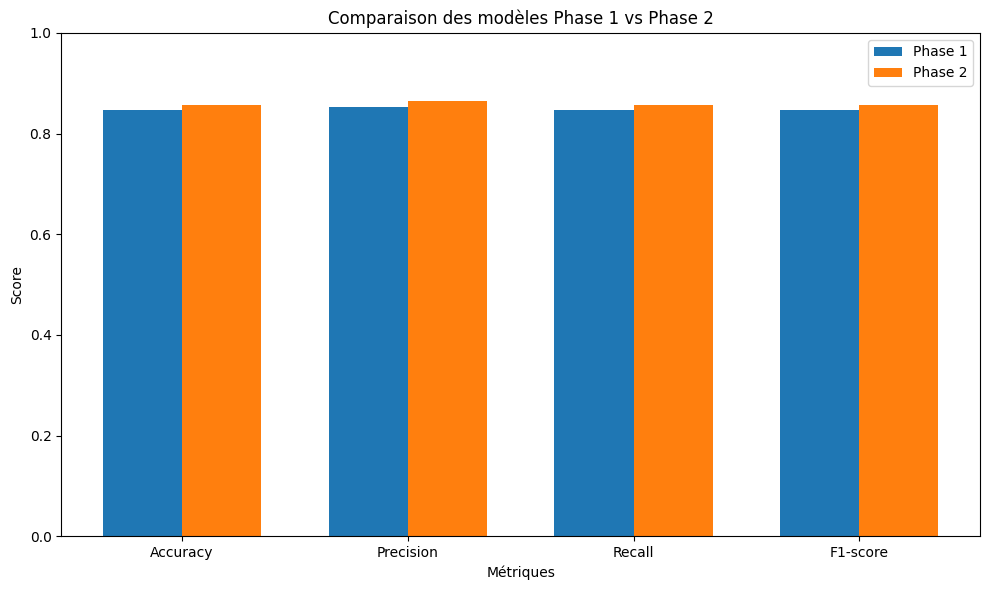

In [ ]:
# Comparer les deux modèles
print("\nComparaison des modèles :")
metrics_comparison = {
    "Métrique": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Phase 1": [
        phase1_metrics["accuracy"],
        phase1_metrics["precision"],
        phase1_metrics["recall"],
        phase1_metrics["f1_score"]
    ],
    "Phase 2": [
        phase2_metrics["accuracy"],
        phase2_metrics["precision"],
        phase2_metrics["recall"],
        phase2_metrics["f1_score"]
    ],
    "Différence": [
        phase2_metrics["accuracy"] - phase1_metrics["accuracy"],
        phase2_metrics["precision"] - phase1_metrics["precision"],
        phase2_metrics["recall"] - phase1_metrics["recall"],
        phase2_metrics["f1_score"] - phase1_metrics["f1_score"]
    ]
}

# Afficher le tableau de comparaison
comparison_df = pd.DataFrame(metrics_comparison)
print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print()


# Sauvegarder la comparaison
comparison_df.to_csv(os.path.join(run_folder, "model_comparison.csv"), index=False)

# Créer une visualisation comparative
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(4)

plt.bar(index, metrics_comparison["Phase 1"], bar_width, label='Phase 1')
plt.bar(index + bar_width, metrics_comparison["Phase 2"], bar_width, label='Phase 2')

plt.xlabel('Métriques')
plt.ylabel('Score')
plt.title('Comparaison des modèles Phase 1 vs Phase 2')
plt.xticks(index + bar_width / 2, metrics_comparison["Métrique"])
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(run_folder, "model_comparison.png"), dpi=300)
plt.show()